
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_19480/2489131591.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


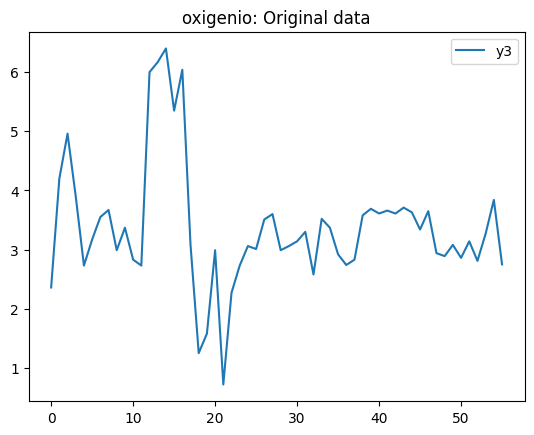

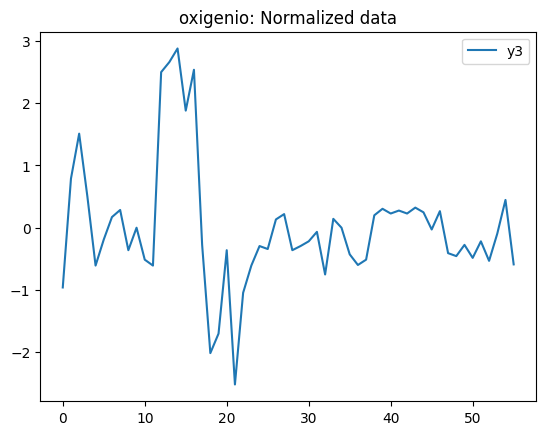

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import plotly.express as px

scaler = StandardScaler()

def getData(output, label):
    df_orig = pd.read_excel("../../../data.xlsx")
    df_orig.plot(y=[output], title=f"{label}: Original data")
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df.plot(y=[output], title=f"{label}: Normalized data")
    return (df)

def create_dataframe(output, label):
    df = getData(output, label)
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    return output, input

output, input = create_dataframe(output="y3", label="oxigenio")



In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-03-28 20:12:56.579357: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 20:12:59.141402: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 20:12:59.141504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 20:12:59.516366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 20:13:00.351272: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 20:13:00.352480: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error


class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
 
 
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
          self.test_prediction = self.lm_model.predict(self.test_input)

          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.test_prediction.flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()

          r2 = r2_score(self.output, pred)
          r2_test = r2_score(self.test_output, test_pred)
          r2_val = r2_score(self.val_output, val_pred)
          r2_vt = r2_score(self.vt_output, vt_pred)

          mse = mean_squared_error(self.output, pred)
          mse_test = mean_squared_error(self.test_output, test_pred)
          mse_val = mean_squared_error(self.val_output, val_pred)
          mse_vt = mean_squared_error(self.vt_output, vt_pred)

          metrics = {
                          'r2': r2,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt
                          }

          return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._train, trainer._vt, trainer._val, trainer._test), f)


  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[5], [10], [15], [20], [25], [30], [35], [40], [45]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinacao1: Hidden Size=[5], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  2.1848710679996657
Stopped at epoch:  12
1/1 [==============================] - 0s 37ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.544594042999961
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.5076216789998398
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.5916039600001568
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.5116964940002617
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.5421750320001593
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [1_0] | 7 +++++++++++++++

2024-03-28 20:14:16.461549: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.4930885280000439
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_3] | 1 ++++++++++++++++++
Elapsed time:  0.6571671659999083
Stopped at epoch:  10
1/1 [==============================] - 0s 31ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Elapsed time:  0.8255497579998519
Stopped at epoch:  10
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Elapsed time:  0.712680291000197
Stopped at epoch:  10
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Elapsed time:  0.5576687120001225
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Elapsed time:  0.968173964000016
Stopped at epoch:  11
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Elapsed time:  1.494437597000342
Stopped at epoch:  20
1/1 [==============================] - 0s 26ms/step
+++

2024-03-28 20:15:08.423661: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  1.4077025599999615
Stopped at epoch:  26
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Elapsed time:  0.6392789250003261
Stopped at epoch:  9
1/1 [==============================] - 0s 18ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Elapsed time:  0.7562483339997925
Stopped at epoch:  9
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Elapsed time:  0.452692740999737
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Elapsed time:  0.5675108810000893
Stopped at epoch:  8
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Elapsed time:  0.6275214329998562
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Elapsed time:  0.4384670169997662
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_2_2_0,0.808529,0.859175,0.841953,0.853999,0.191471,0.20711,0.157843,0.183926


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Elapsed time:  0.06662588700010019
Stopped at epoch:  0
1/1 [==============================] - 0s 29ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Elapsed time:  0.050937384000008024
Stopped at epoch:  0
1/1 [==============================] - 0s 48ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Elapsed time:  0.04370331699965391
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Elapsed time:  0.056103314999745635
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Elapsed time:  0.04647251699998378
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Elapsed time:  0.05334338900001967
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Elapsed time:  0.0707

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_0_0,0.819088,0.192348,0.153611,0.213140,0.180912,0.364919,0.369121,0.366897
model_3_0_1,0.835840,0.237599,0.158655,0.238575,0.164160,0.344473,0.366921,0.355037
model_3_0_2,0.848489,0.264261,0.159271,0.252523,0.151511,0.332427,0.366653,0.348533
model_3_0_3,0.857968,0.277651,0.156822,0.258314,0.142032,0.326377,0.367721,0.345833
model_3_0_4,0.864988,0.281536,0.152265,0.258301,0.135012,0.324622,0.369708,0.345839
model_3_0_5,0.870100,0.278668,0.146296,0.254203,0.129900,0.325917,0.372311,0.347750
model_3_0_6,0.873734,0.271054,0.139426,0.247273,0.126266,0.329358,0.375307,0.350981
model_3_0_19,0.874668,0.099945,0.057858,0.123592,0.125332,0.406669,0.410880,0.408651
model_3_0_18,0.875368,0.110144,0.062013,0.130653,0.124632,0.402061,0.409068,0.405358
model_3_0_17,0.876079,0.121143,0.066539,0.138287,0.123921,0.397092,0.407094,0.401799


DataFrame salvo em ../results/metrics_3_0
+++++++++++ [3_1] | 1 ++++++++++++++++++
Elapsed time:  0.5151540910001131
Stopped at epoch:  9
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Elapsed time:  0.33676733700031036
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_1] | 3 ++++++++++++++++++
Elapsed time:  0.366172061999805
Stopped at epoch:  6
1/1 [==============================] - 0s 47ms/step
+++++++++++ [3_1] | 4 ++++++++++++++++++
Elapsed time:  0.3431398860002446
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_1] | 5 ++++++++++++++++++
Elapsed time:  0.34462565800004086
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_1] | 6 ++++++++++++++++++
Elapsed time:  0.362598799999887
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [3_1] | 7 ++++++++++++++++++
Elapsed time:  0.372525066999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_1_2,0.823967,-0.969199,-0.547875,-0.911332,0.176033,0.873974,0.075456,0.498201
model_3_1_1,0.848564,-0.637254,0.454781,-0.523861,0.151436,0.726649,0.026578,0.397204
model_3_1_0,0.866232,-0.313527,0.725684,-0.208201,0.133768,0.582972,0.013372,0.314925


DataFrame salvo em ../results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Elapsed time:  0.31406559099968945
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Elapsed time:  0.364765497999997
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Elapsed time:  0.3759899570000016
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Elapsed time:  0.35499680400016587
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Elapsed time:  0.353231704999871
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_2] | 6 ++++++++++++++++++
Elapsed time:  0.39046518499981175
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_2] | 7 ++++++++++++++++++
Elapsed time:  0.37998745899

2024-03-28 20:19:47.662709: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3591568599999846
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_4] | 21 ++++++++++++++++++
Elapsed time:  0.33407440600012706
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [3_4] | 22 ++++++++++++++++++
Elapsed time:  0.44901249900021867
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_4] | 23 ++++++++++++++++++
Elapsed time:  0.3189573899999232
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [3_4] | 24 ++++++++++++++++++
Elapsed time:  0.3154200349999883
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_4] | 25 ++++++++++++++++++
Elapsed time:  0.32880912900009207
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [3_5] | 1 ++++++++++++++++++
Elapsed time:  0.41348753499960367
Stopped at epoch:  7
1/1 [==============================] - 0s 35ms/s

2024-03-28 20:20:09.039406: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_5] | 25 ++++++++++++++++++
Elapsed time:  0.2991810080002324
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_5_0,0.801082,0.478547,0.622352,0.551030,0.198918,0.670785,0.470381,0.576478
model_3_5_1,0.803159,0.483077,0.602997,0.544598,0.196841,0.664957,0.494488,0.584737
model_3_5_2,0.804887,0.488305,0.585818,0.539528,0.195113,0.658232,0.515886,0.591246
model_3_5_3,0.806313,0.493820,0.570603,0.535509,0.193687,0.651138,0.534837,0.596407
model_3_5_4,0.807483,0.499369,0.557142,0.532306,0.192517,0.644000,0.551603,0.600519
model_3_5_5,0.808437,0.504781,0.545232,0.529740,0.191563,0.637038,0.566438,0.603814
model_3_5_6,0.809210,0.509957,0.534682,0.527670,0.190790,0.630379,0.579578,0.606473
model_3_5_7,0.809831,0.514839,0.525325,0.525987,0.190169,0.624100,0.591233,0.608633
model_3_5_8,0.810326,0.519393,0.517011,0.524608,0.189674,0.618241,0.601588,0.610404
model_3_5_9,0.810717,0.523612,0.509614,0.523468,0.189283,0.612815,0.610802,0.611868


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Elapsed time:  0.35254449099966223
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Elapsed time:  0.39586421400008476
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Elapsed time:  0.4239677909999955
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Elapsed time:  0.38336004899974796
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Elapsed time:  0.29611953600033303
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Elapsed time:  0.3051834470002177
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Elapsed time:  0.38856034

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_14,0.803362,-1.719310,0.782060,0.570241,0.196638,0.740740,0.511443,0.632836
model_3_6_13,0.807988,-1.663118,0.791689,0.582966,0.192012,0.725434,0.488846,0.614098
model_3_6_12,0.812873,-1.602350,0.802236,0.596827,0.187127,0.708880,0.464095,0.593687
model_3_6_11,0.817980,-1.536923,0.813757,0.611875,0.182020,0.691058,0.437059,0.571529
model_3_6_10,0.823253,-1.466846,0.826298,0.628143,0.176747,0.671969,0.407628,0.547573
model_3_6_9,0.828604,-1.392297,0.839894,0.645640,0.171396,0.651662,0.375724,0.521809
model_3_6_0,0.830803,-0.766802,0.986124,0.816563,0.169197,0.481277,0.032562,0.270117
model_3_6_8,0.833912,-1.313648,0.854553,0.664336,0.166088,0.630238,0.341322,0.494277
model_3_6_7,0.838998,-1.231595,0.870252,0.684145,0.161002,0.607887,0.304482,0.465108
model_3_6_1,0.842404,-0.787226,0.973579,0.805155,0.157596,0.486840,0.062002,0.286917


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.4092517770000086
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.33418345900008717
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.41052114400008577
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.3673603570000523
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.34153046599976733
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.3948645199998282
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.444370514

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_0,0.815745,0.942989,0.988549,0.948542,0.184255,0.145023,0.004546,0.078916
model_3_7_1,0.848684,0.952961,0.958132,0.953594,0.151316,0.119656,0.016620,0.071168
model_3_7_2,0.873409,0.959197,0.914586,0.953766,0.126591,0.103794,0.033906,0.070906
model_3_7_3,0.891816,0.962855,0.861988,0.950571,0.108184,0.094489,0.054786,0.075805
model_3_7_24,0.903686,0.943415,-0.271946,0.795378,0.096314,0.143939,0.504918,0.313811
model_3_7_23,0.905300,0.944400,-0.246248,0.799373,0.094700,0.141434,0.494717,0.307685
model_3_7_4,0.905322,0.964745,0.802930,0.945037,0.094678,0.089681,0.078230,0.084292
model_3_7_22,0.907051,0.945468,-0.217713,0.803786,0.092949,0.138717,0.483389,0.300916
model_3_7_21,0.908943,0.946621,-0.186066,0.808654,0.091057,0.135784,0.470827,0.293451
model_3_7_20,0.910971,0.947858,-0.151066,0.814004,0.089029,0.132637,0.456933,0.285247


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.37135949399998935
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.3375023870003133
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.3677965500000937
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.38600075300018943
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.3652759110000261
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.3689703270001701
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.3065307500

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_0,0.915859,0.730723,0.964086,0.851669,0.084141,0.278564,0.033616,0.163295
model_3_8_1,0.925202,0.750303,0.960399,0.859934,0.074798,0.258310,0.037068,0.154196
model_3_8_2,0.932271,0.764684,0.955584,0.865162,0.067729,0.243433,0.041575,0.148441
model_3_8_3,0.937522,0.774838,0.950017,0.867986,0.062478,0.232928,0.046786,0.145332
model_3_8_24,0.937731,0.743833,0.854484,0.814337,0.062269,0.265002,0.136208,0.204393
model_3_8_23,0.938276,0.745726,0.856593,0.816123,0.061724,0.263044,0.134233,0.202427
model_3_8_22,0.938863,0.747781,0.858901,0.818069,0.061137,0.260919,0.132073,0.200285
model_3_8_21,0.939491,0.750005,0.861423,0.820184,0.060509,0.258618,0.129712,0.197956
model_3_8_20,0.940160,0.752401,0.864173,0.822477,0.059840,0.256138,0.127138,0.195432
model_3_8_19,0.940867,0.754974,0.867166,0.824954,0.059133,0.253478,0.124337,0.192705


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.389714419000029
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.37785403499992753
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.3820009650003158
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.32948743099996136
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.31730288599965206
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.4284888340002908
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.3714706109

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_24,0.869190,-0.545462,0.772390,0.487445,0.130810,0.529890,0.318059,0.430205
model_3_9_23,0.870954,-0.519039,0.774179,0.494561,0.129046,0.520831,0.315559,0.424232
model_3_9_22,0.872918,-0.489767,0.776244,0.502509,0.127082,0.510794,0.312673,0.417560
model_3_9_21,0.875106,-0.457369,0.778639,0.511392,0.124894,0.499686,0.309327,0.410105
model_3_9_20,0.877543,-0.421540,0.781422,0.521321,0.122457,0.487401,0.305438,0.401772
model_3_9_19,0.880258,-0.381968,0.784668,0.532422,0.119742,0.473833,0.300902,0.392454
model_3_9_18,0.883281,-0.338327,0.788469,0.544838,0.116719,0.458870,0.295591,0.382033
model_3_9_17,0.886647,-0.290289,0.792933,0.558724,0.113353,0.442399,0.289353,0.370378
model_3_9_16,0.890391,-0.237541,0.798195,0.574255,0.109609,0.424314,0.282000,0.357342
model_3_9_15,0.894553,-0.179805,0.804416,0.591615,0.105447,0.404518,0.273306,0.342771


DataFrame salvo em ../results/metrics_3_9
Testando combinacao4: Hidden Size=[10], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.6181609979998939
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.42774701799999093
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.3832002939998347
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.34384774799991646
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.28739409000036176
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.3573125129996697
Stopped at epoch:  6
1/1 [==============================] - 0s 19

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_1_0,0.805980,0.741371,0.330095,0.665768,0.194020,0.377926,0.356818,0.367993
model_4_1_1,0.816403,0.702425,0.376045,0.648865,0.183597,0.434835,0.332343,0.386604
model_4_1_19,0.819267,0.481869,0.242614,0.463518,0.180733,0.757125,0.403414,0.590673
model_4_1_18,0.821456,0.487457,0.258518,0.471064,0.178544,0.748961,0.394943,0.582364
model_4_1_17,0.823766,0.493534,0.275516,0.479205,0.176234,0.740080,0.385889,0.573401
model_4_1_2,0.825332,0.663262,0.440896,0.636111,0.174668,0.492063,0.297801,0.400645
model_4_1_16,0.826179,0.500128,0.293562,0.487945,0.173821,0.730445,0.376277,0.563778
model_4_1_15,0.828671,0.507252,0.312556,0.497275,0.171329,0.720035,0.366160,0.553506
model_4_1_14,0.831202,0.514914,0.332332,0.507161,0.168798,0.708838,0.355626,0.542621
model_4_1_13,0.833716,0.523108,0.352627,0.517539,0.166284,0.696864,0.344817,0.531195


DataFrame salvo em ../results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Elapsed time:  0.4045842619998439
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Elapsed time:  0.3248728469998241
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Elapsed time:  0.3754321090000303
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Elapsed time:  0.3361876240001038
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Elapsed time:  0.4194759580000209
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_2] | 6 ++++++++++++++++++
Elapsed time:  0.3249723530002484
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_2] | 7 ++++++++++++++++++
Elapsed time:  0.360467666999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_2_0,0.847462,0.796469,-0.141216,0.693309,0.152538,0.125985,0.158775,0.141415
model_4_2_1,0.863521,0.736779,-0.120712,0.653799,0.136479,0.162933,0.155922,0.159634
model_4_2_5,0.866450,0.317515,-0.396046,0.316733,0.133550,0.422456,0.194229,0.315055
model_4_2_4,0.866679,0.402884,-0.363399,0.382041,0.133321,0.369613,0.189687,0.284942
model_4_2_24,0.869971,0.293351,-1.971740,0.075827,0.130029,0.437414,0.413452,0.426137
model_4_2_23,0.870620,0.290612,-1.917566,0.081573,0.129380,0.439108,0.405914,0.423488
model_4_2_6,0.870655,0.290468,-0.421230,0.293936,0.129345,0.439198,0.197733,0.325567
model_4_2_3,0.870951,0.543360,-0.296943,0.491313,0.129049,0.282659,0.180441,0.234556
model_4_2_2,0.871027,0.658846,-0.187501,0.588929,0.128973,0.211173,0.165214,0.189545
model_4_2_22,0.871282,0.287501,-1.858995,0.087679,0.128718,0.441034,0.397766,0.420672


DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Elapsed time:  0.4323746579998442
Stopped at epoch:  8
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Elapsed time:  0.32840680000026623
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Elapsed time:  0.35871270400002686
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Elapsed time:  0.3276975449998645
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Elapsed time:  0.3593321180001112
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Elapsed time:  0.3718202640002346
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Elapsed time:  0.3006685499

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_3_24,0.830338,0.641822,0.647125,0.648977,0.169662,0.541959,0.575031,0.557522
model_4_3_23,0.831781,0.644227,0.651228,0.652171,0.168219,0.538320,0.568345,0.552449
model_4_3_22,0.833381,0.646908,0.655817,0.655739,0.166619,0.534263,0.560867,0.546783
model_4_3_21,0.835156,0.649896,0.660953,0.659725,0.164844,0.529742,0.552498,0.540451
model_4_3_20,0.837122,0.653227,0.666701,0.664181,0.162878,0.524701,0.543131,0.533374
model_4_3_19,0.839298,0.656941,0.673134,0.669160,0.160702,0.519082,0.532648,0.525466
model_4_3_18,0.841704,0.661083,0.680334,0.674725,0.158296,0.512815,0.520916,0.516627
model_4_3_17,0.844360,0.665701,0.688388,0.680943,0.155640,0.505828,0.507790,0.506752
model_4_3_16,0.847287,0.670850,0.697391,0.687887,0.152713,0.498037,0.493119,0.495723
model_4_3_15,0.850502,0.676592,0.707436,0.695633,0.149498,0.489348,0.476751,0.483420


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Elapsed time:  0.6292646819997572
Stopped at epoch:  11
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Elapsed time:  0.3496499760003644
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Elapsed time:  0.31187264199979836
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Elapsed time:  0.3578533200002312
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Elapsed time:  0.3768755279998004
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Elapsed time:  0.34465482099994915
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Elapsed time:  0.396849800

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_4_0,0.895062,0.847317,-0.497598,0.743472,0.104938,0.254272,0.282743,0.267670
model_4_4_24,0.897747,0.883105,-1.625726,0.677653,0.102253,0.194673,0.495732,0.336348
model_4_4_23,0.898005,0.882938,-1.613251,0.678575,0.101995,0.194951,0.493377,0.335386
model_4_4_22,0.898284,0.882746,-1.599400,0.679592,0.101716,0.195271,0.490762,0.334325
model_4_4_1,0.898411,0.852247,-0.589770,0.739789,0.101589,0.246063,0.300145,0.271514
model_4_4_21,0.898586,0.882523,-1.584019,0.680713,0.101414,0.195643,0.487858,0.333156
model_4_4_20,0.898912,0.882264,-1.566950,0.681948,0.101088,0.196073,0.484635,0.331867
model_4_4_19,0.899263,0.881964,-1.548002,0.683307,0.100737,0.196573,0.481058,0.330448
model_4_4_18,0.899637,0.881615,-1.526975,0.684803,0.100363,0.197154,0.477088,0.328888
model_4_4_17,0.900035,0.881209,-1.503647,0.686446,0.099965,0.197830,0.472684,0.327173


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Elapsed time:  0.37907623399996737
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Elapsed time:  0.2833188509998763
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Elapsed time:  0.3976783759999307
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Elapsed time:  0.34364721199972337
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Elapsed time:  0.32674397999971916
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Elapsed time:  0.3517925229998582
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Elapsed time:  0.336731648

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_5_4,0.815624,-0.682512,-0.355988,-0.535967,0.184376,0.800611,0.294303,0.562348
model_4_5_3,0.847718,-0.352057,-0.030606,-0.217819,0.152282,0.643366,0.223682,0.445868
model_4_5_2,0.878666,-0.011150,0.257521,0.097128,0.121334,0.481148,0.161147,0.330559
model_4_5_1,0.902456,0.280052,0.473910,0.357862,0.097544,0.342582,0.114182,0.235100
model_4_5_0,0.909441,0.424045,0.557885,0.480366,0.090559,0.274064,0.095956,0.190249


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Elapsed time:  0.3816517019999992
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Elapsed time:  0.301704091999909
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Elapsed time:  0.37670153599992773
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Elapsed time:  0.38963745399996697
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Elapsed time:  0.34791922099975636
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Elapsed time:  0.34023617599996214
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Elapsed time:  0.401397290

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_7_3,0.800570,0.739952,-3.675721,0.427372,0.199430,0.475971,0.851740,0.652803
model_4_7_2,0.801909,0.744782,-3.667855,0.432069,0.198091,0.467131,0.850307,0.647449
model_4_7_1,0.803060,0.749600,-3.664698,0.436402,0.196940,0.458311,0.849732,0.642509
model_4_7_0,0.803974,0.754398,-3.667420,0.440275,0.196026,0.449530,0.850228,0.638094


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Elapsed time:  0.3283580060001441
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Elapsed time:  0.29918515500003195
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Elapsed time:  0.3285477929998706
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Elapsed time:  0.4291780349999499
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Elapsed time:  0.35157386600030804
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Elapsed time:  0.3856590129998949
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Elapsed time:  0.2904733010

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_0,0.847150,0.448910,0.338078,0.429523,0.152850,0.255987,0.365917,0.307719
model_4_9_1,0.857352,0.445499,0.327550,0.422891,0.142648,0.257572,0.371738,0.311297
model_4_9_2,0.865302,0.442346,0.315501,0.415643,0.134698,0.259036,0.378398,0.315206
model_4_9_3,0.871407,0.439210,0.302094,0.407747,0.128593,0.260493,0.385810,0.319466
model_4_9_24,0.876009,0.361868,0.038009,0.245123,0.123991,0.296419,0.531799,0.407186
model_4_9_4,0.876009,0.435951,0.287561,0.399252,0.123991,0.262007,0.393844,0.324048
model_4_9_23,0.876601,0.364224,0.044422,0.249290,0.123399,0.295325,0.528253,0.404938
model_4_9_22,0.877235,0.366777,0.051429,0.253833,0.122765,0.294139,0.524380,0.402488
model_4_9_21,0.877908,0.369534,0.059067,0.258774,0.122092,0.292858,0.520158,0.399822
model_4_9_20,0.878617,0.372502,0.067375,0.264134,0.121383,0.291480,0.515565,0.396932


DataFrame salvo em ../results/metrics_4_9
Testando combinacao5: Hidden Size=[15], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.588566419000017
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.7189939229997435
Stopped at epoch:  11
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.3930492750000667
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.3411478950001765
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.33796704599990335
Stopped at epoch:  6
1/1 [==============================] - 0s 43ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.3366369710001891
Stopped at epoch:  6
1/1 [==============================] - 0s 23m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_1_0,0.805472,0.913414,-1.857721,0.843611,0.194528,0.173716,0.180818,0.177058
model_5_1_1,0.819757,0.889736,-2.304959,0.809635,0.180243,0.221221,0.209116,0.215525
model_5_1_2,0.831958,0.883613,-3.048209,0.784343,0.168042,0.233506,0.256144,0.244159
model_5_1_3,0.839209,0.883469,-4.176650,0.754531,0.160791,0.233794,0.327544,0.277912
model_5_1_23,0.841869,0.845576,-10.866376,0.543042,0.158131,0.309820,0.750826,0.517352
model_5_1_22,0.844316,0.848784,-10.682164,0.550897,0.155684,0.303383,0.739170,0.508459
model_5_1_21,0.846936,0.852281,-10.482358,0.559432,0.153064,0.296368,0.726528,0.498796
model_5_1_4,0.847987,0.890116,-5.082157,0.736952,0.152013,0.220459,0.384839,0.297814
model_5_1_20,0.849728,0.856083,-10.266378,0.568680,0.150272,0.288739,0.712862,0.488326
model_5_1_19,0.852682,0.860209,-10.033808,0.578667,0.147318,0.280461,0.698146,0.477019


DataFrame salvo em ../results/metrics_5_1
+++++++++++ [5_2] | 1 ++++++++++++++++++
Elapsed time:  0.40866032300027655
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_2] | 2 ++++++++++++++++++
Elapsed time:  0.2886229219998313
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_2] | 3 ++++++++++++++++++
Elapsed time:  0.36133319200007463
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_2] | 4 ++++++++++++++++++
Elapsed time:  0.28870933099960894
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_2] | 5 ++++++++++++++++++
Elapsed time:  0.32540002099995036
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_2] | 6 ++++++++++++++++++
Elapsed time:  0.30980246200033434
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [5_2] | 7 ++++++++++++++++++
Elapsed time:  0.3233301

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_2_0,0.862026,0.574457,0.881625,0.717652,0.137974,0.346847,0.049333,0.206840
model_5_2_1,0.877698,0.598668,0.857881,0.725556,0.122302,0.327113,0.059229,0.201050
model_5_2_2,0.889921,0.620894,0.822580,0.729197,0.110079,0.308997,0.073941,0.198382
model_5_2_3,0.899434,0.641249,0.780584,0.729944,0.100566,0.292407,0.091443,0.197835
model_5_2_4,0.906769,0.659690,0.734958,0.728592,0.093231,0.277375,0.110458,0.198826
model_5_2_5,0.912333,0.676175,0.687650,0.725637,0.087667,0.263939,0.130173,0.200991
model_5_2_24,0.916122,0.770097,0.105055,0.624990,0.083878,0.187387,0.372973,0.274721
model_5_2_6,0.916459,0.690719,0.639995,0.721446,0.083541,0.252085,0.150034,0.204061
model_5_2_23,0.916745,0.769414,0.118927,0.628302,0.083255,0.187943,0.367192,0.272295
model_5_2_22,0.917405,0.768604,0.134143,0.631898,0.082595,0.188603,0.360850,0.269661


DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Elapsed time:  0.3533034689999113
Stopped at epoch:  7
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Elapsed time:  0.3510651259998667
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Elapsed time:  0.3423670779998247
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Elapsed time:  0.3371535569999651
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Elapsed time:  0.3401069319997987
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Elapsed time:  0.35247307200006617
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Elapsed time:  0.35208649000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_24,0.910111,0.493007,-1.289174,0.032146,0.089889,0.208102,0.394245,0.295699
model_5_3_23,0.911246,0.495885,-1.249580,0.044696,0.088754,0.206920,0.387426,0.291864
model_5_3_22,0.912487,0.499045,-1.206183,0.058456,0.087513,0.205623,0.379952,0.287660
model_5_3_21,0.913839,0.502508,-1.158699,0.073514,0.086161,0.204202,0.371774,0.283060
model_5_3_20,0.915310,0.506294,-1.106864,0.089957,0.084690,0.202648,0.362847,0.278036
model_5_3_19,0.916904,0.510425,-1.050416,0.107870,0.083096,0.200953,0.353126,0.272563
model_5_3_18,0.918625,0.514914,-0.989129,0.127321,0.081375,0.199110,0.342571,0.266621
model_5_3_17,0.920475,0.519780,-0.922817,0.148372,0.079525,0.197113,0.331150,0.260189
model_5_3_16,0.922452,0.525025,-0.851384,0.171052,0.077548,0.194960,0.318848,0.253260
model_5_3_15,0.924550,0.530642,-0.774824,0.195356,0.075450,0.192654,0.305663,0.245835


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.4157518249999157
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.33939044599992485
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.3190483469998071
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.2977088699999513
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.30840707800007294
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.31102817400005733
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.278528802

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_24,0.897030,0.764202,0.736066,0.754760,0.102970,0.405000,0.262990,0.338172
model_5_4_23,0.898644,0.765967,0.744487,0.758787,0.101356,0.401969,0.254599,0.332619
model_5_4_22,0.900413,0.767988,0.753625,0.763227,0.099587,0.398497,0.245494,0.326496
model_5_4_21,0.902350,0.770311,0.763510,0.768120,0.097650,0.394507,0.235645,0.319749
model_5_4_20,0.904470,0.772991,0.774164,0.773511,0.095530,0.389904,0.225028,0.312315
model_5_4_19,0.906787,0.776099,0.785598,0.779448,0.093213,0.384566,0.213635,0.304128
model_5_4_18,0.909317,0.779722,0.797806,0.785988,0.090683,0.378343,0.201472,0.295109
model_5_4_17,0.912078,0.783977,0.810755,0.793198,0.087922,0.371035,0.188568,0.285168
model_5_4_16,0.915091,0.789014,0.824380,0.801153,0.084909,0.362383,0.174992,0.274199
model_5_4_15,0.918376,0.795023,0.838556,0.809935,0.081624,0.352063,0.160867,0.262088


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.47930773600000975
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.3016799259999061
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.32475680400011697
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.3827917899998283
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.2864274970002043
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.29381150600011097
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.339941175

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.909223,0.084319,0.822137,0.538096,0.090777,0.180960,0.050721,0.119671
model_5_5_1,0.918085,0.041476,0.820086,0.519733,0.081915,0.189427,0.051306,0.124429
model_5_5_24,0.922526,-0.799163,0.509621,0.019448,0.077474,0.355557,0.139842,0.254044
model_5_5_23,0.923118,-0.785538,0.515565,0.028028,0.076882,0.352865,0.138147,0.251821
model_5_5_22,0.923759,-0.770525,0.522109,0.037481,0.076241,0.349898,0.136280,0.249372
model_5_5_2,0.924441,-0.009983,0.811415,0.494461,0.075559,0.199596,0.053779,0.130976
model_5_5_21,0.924451,-0.753997,0.529310,0.047885,0.075549,0.346631,0.134227,0.246676
model_5_5_20,0.925195,-0.735820,0.537222,0.059323,0.074805,0.343039,0.131971,0.243713
model_5_5_19,0.925991,-0.715854,0.545901,0.071882,0.074009,0.339093,0.129496,0.240459
model_5_5_18,0.926836,-0.693954,0.555404,0.085648,0.073164,0.334765,0.126786,0.236893


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.4393525599998611
Stopped at epoch:  8
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.4222390089998953
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.3632585810000819
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.37383182299981854
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.49286281900003814
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.2821809920001215
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.3501884180

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_24,0.906061,-0.393557,0.779141,0.235840,0.093939,0.509554,0.083650,0.309128
model_5_6_23,0.906479,-0.387981,0.781223,0.239425,0.093521,0.507515,0.082861,0.307678
model_5_6_22,0.906938,-0.381796,0.783512,0.243394,0.093062,0.505254,0.081994,0.306073
model_5_6_21,0.907444,-0.374931,0.786026,0.247786,0.092556,0.502744,0.081042,0.304296
model_5_6_20,0.907998,-0.367317,0.788783,0.252645,0.092002,0.499959,0.079998,0.302330
model_5_6_19,0.908605,-0.358873,0.791801,0.258015,0.091395,0.496872,0.078855,0.300158
model_5_6_18,0.909269,-0.349510,0.795100,0.263949,0.090731,0.493448,0.077605,0.297757
model_5_6_17,0.909994,-0.339134,0.798698,0.270500,0.090006,0.489654,0.076243,0.295108
model_5_6_16,0.910782,-0.327639,0.802612,0.277725,0.089218,0.485451,0.074760,0.292185
model_5_6_15,0.911638,-0.314911,0.806858,0.285686,0.088362,0.480797,0.073152,0.288964


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.3749134609997782
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.3550733560000481
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.3289730840001539
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.3798308899999938
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.3279703530001825
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.29846160499982943
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.26298513900

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_0,0.919881,0.995348,0.906959,0.938829,0.080119,0.002319,0.116284,0.055950
model_5_7_1,0.930535,0.986645,0.903830,0.934306,0.069465,0.006658,0.120194,0.060087
model_5_7_2,0.938689,0.974382,0.900902,0.928885,0.061311,0.012771,0.123854,0.065046
model_5_7_3,0.944871,0.959891,0.898140,0.922927,0.055129,0.019996,0.127306,0.070494
model_5_7_4,0.949501,0.944115,0.895535,0.916700,0.050499,0.027861,0.130562,0.076191
model_5_7_5,0.952910,0.927722,0.893083,0.910393,0.047090,0.036033,0.133626,0.081959
model_5_7_24,0.953972,0.720373,0.869994,0.835714,0.046028,0.139403,0.162483,0.150264
model_5_7_23,0.954366,0.725452,0.870463,0.837481,0.045634,0.136871,0.161898,0.148648
model_5_7_22,0.954785,0.731019,0.870980,0.839420,0.045215,0.134096,0.161251,0.146875
model_5_7_21,0.955228,0.737112,0.871550,0.841545,0.044772,0.131058,0.160538,0.144931


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.524657120000029
Stopped at epoch:  9
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.34344693000002735
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.4000013869999748
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.28081387099973654
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.3730591749999803
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.3938056150000193
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.34941051200

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_0,0.977518,0.994423,0.960961,0.989230,0.022482,0.010021,0.019704,0.014578
model_5_8_1,0.980659,0.993996,0.958223,0.988449,0.019341,0.010789,0.021086,0.015635
model_5_8_2,0.983126,0.993529,0.955554,0.987653,0.016874,0.011628,0.022434,0.016713
model_5_8_3,0.985056,0.993039,0.952991,0.986859,0.014944,0.012508,0.023727,0.017788
model_5_8_4,0.986560,0.992540,0.950553,0.986080,0.013440,0.013406,0.024958,0.018842
model_5_8_5,0.987723,0.992041,0.948248,0.985324,0.012277,0.014303,0.026121,0.019864
model_5_8_6,0.988616,0.991551,0.946076,0.984599,0.011384,0.015184,0.027217,0.020846
model_5_8_7,0.989296,0.991075,0.944039,0.983907,0.010704,0.016038,0.028245,0.021783
model_5_8_8,0.989806,0.990619,0.942134,0.983252,0.010194,0.016858,0.029207,0.022669
model_5_8_9,0.990184,0.990184,0.940357,0.982635,0.009816,0.017639,0.030104,0.023505


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  1.3021680289998585
Stopped at epoch:  26
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.3988880400002017
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.38527800399970147
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.31441547899976285
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.3765484280002056
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.327729716000249
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.3523600100

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_24,0.994197,0.983513,0.993654,0.988269,0.005803,0.027728,0.009425,0.019115
model_5_9_23,0.994202,0.983532,0.993653,0.988279,0.005798,0.027695,0.009427,0.019098
model_5_9_22,0.994207,0.983554,0.993652,0.988290,0.005793,0.027659,0.009429,0.019080
model_5_9_21,0.994213,0.983578,0.993650,0.988303,0.005787,0.027619,0.009431,0.019060
model_5_9_20,0.994220,0.983604,0.993649,0.988316,0.005780,0.027575,0.009433,0.019038
model_5_9_19,0.994227,0.983633,0.993647,0.988332,0.005773,0.027525,0.009436,0.019013
model_5_9_18,0.994235,0.983666,0.993645,0.988348,0.005765,0.027470,0.009439,0.018985
model_5_9_17,0.994244,0.983702,0.993643,0.988367,0.005756,0.027410,0.009442,0.018954
model_5_9_16,0.994254,0.983742,0.993640,0.988388,0.005746,0.027342,0.009446,0.018921
model_5_9_15,0.994265,0.983786,0.993637,0.988411,0.005735,0.027268,0.009451,0.018883


DataFrame salvo em ../results/metrics_5_9
Testando combinacao6: Hidden Size=[15], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.9204215340000701
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.439297044000341
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.3304619279997496
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.30704944799981604
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.327307280000241
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.36891976499964585
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_1_20,0.809281,0.439171,0.787071,0.632053,0.190719,0.811574,0.413470,0.624231
model_6_1_19,0.812865,0.452524,0.789826,0.639566,0.187135,0.792252,0.408121,0.611484
model_6_1_18,0.816735,0.467191,0.792751,0.647765,0.183265,0.771026,0.402441,0.597575
model_6_1_17,0.820890,0.483248,0.795835,0.656677,0.179110,0.747790,0.396453,0.582455
model_6_1_0,0.821635,0.755301,0.857509,0.812750,0.178365,0.354103,0.276693,0.317674
model_6_1_16,0.825320,0.500756,0.799063,0.666322,0.174680,0.722455,0.390184,0.566092
model_6_1_15,0.830004,0.519746,0.802412,0.676702,0.169996,0.694975,0.383680,0.548483
model_6_1_14,0.834904,0.540217,0.805855,0.687801,0.165096,0.665351,0.376994,0.529654
model_6_1_1,0.839239,0.769442,0.852263,0.816310,0.160761,0.333640,0.286878,0.311634
model_6_1_13,0.839962,0.562116,0.809359,0.699577,0.160038,0.633661,0.370191,0.509675


DataFrame salvo em ../results/metrics_6_1
+++++++++++ [6_2] | 1 ++++++++++++++++++
Elapsed time:  0.4542257000002792
Stopped at epoch:  8
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_2] | 2 ++++++++++++++++++
Elapsed time:  0.32344850399977076
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_2] | 3 ++++++++++++++++++
Elapsed time:  0.3521576130001449
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [6_2] | 4 ++++++++++++++++++
Elapsed time:  0.3291219419998015
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_2] | 5 ++++++++++++++++++
Elapsed time:  0.3673420629997963
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_2] | 6 ++++++++++++++++++
Elapsed time:  0.39586533500005316
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_2] | 7 ++++++++++++++++++
Elapsed time:  0.3379531549

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_2_24,0.808748,0.758154,0.565926,0.638672,0.191252,0.275797,1.025565,0.628629
model_6_2_23,0.811397,0.759092,0.573559,0.643875,0.188603,0.274727,1.007533,0.619577
model_6_2_22,0.814299,0.760155,0.581939,0.649600,0.185701,0.273515,0.987734,0.609618
model_6_2_21,0.817472,0.761363,0.591125,0.655890,0.182528,0.272138,0.966029,0.598675
model_6_2_20,0.820932,0.762736,0.601180,0.662792,0.179068,0.270572,0.942273,0.586667
model_6_2_19,0.824698,0.764300,0.612162,0.670353,0.175302,0.268788,0.916326,0.573512
model_6_2_18,0.828784,0.766083,0.624133,0.678622,0.171216,0.266754,0.888043,0.559125
model_6_2_17,0.833202,0.768120,0.637147,0.687645,0.166798,0.264431,0.857296,0.543427
model_6_2_16,0.837961,0.770449,0.651253,0.697469,0.162039,0.261776,0.823967,0.526337
model_6_2_15,0.843062,0.773112,0.666492,0.708131,0.156938,0.258739,0.787965,0.507787


DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Elapsed time:  0.5638614469999084
Stopped at epoch:  11
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Elapsed time:  0.3713022789997922
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Elapsed time:  0.33097505900013857
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Elapsed time:  0.3314422379999087
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Elapsed time:  0.3410746689996813
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Elapsed time:  0.3537334309999096
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Elapsed time:  0.3325695610

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_24,0.854836,0.635200,0.737284,0.701430,0.145164,0.389041,0.577871,0.477902
model_6_3_23,0.855214,0.637340,0.737382,0.702248,0.144786,0.386759,0.577655,0.476592
model_6_3_22,0.855627,0.639702,0.737487,0.703149,0.144373,0.384239,0.577424,0.475150
model_6_3_21,0.856077,0.642308,0.737598,0.704140,0.143923,0.381461,0.577179,0.473563
model_6_3_20,0.856568,0.645179,0.737715,0.705229,0.143432,0.378398,0.576922,0.471821
model_6_3_19,0.857102,0.648341,0.737837,0.706423,0.142898,0.375026,0.576654,0.469910
model_6_3_18,0.857679,0.651820,0.737962,0.707731,0.142321,0.371316,0.576379,0.467817
model_6_3_17,0.858302,0.655642,0.738088,0.709160,0.141698,0.367240,0.576102,0.465528
model_6_3_16,0.858972,0.659835,0.738212,0.710720,0.141028,0.362768,0.575830,0.463033
model_6_3_15,0.859687,0.664428,0.738329,0.712416,0.140313,0.357870,0.575571,0.460318


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.3939456269999937
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.4429515580000043
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.3316830469998422
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.3273839630001021
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.37776463699992746
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.2913346469999851
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.39965604299

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_24,0.827693,0.653042,0.605351,0.646421,0.172307,0.728307,0.383040,0.565828
model_6_4_23,0.829919,0.658498,0.609032,0.651261,0.170081,0.716852,0.379467,0.558083
model_6_4_22,0.832362,0.664522,0.613116,0.656609,0.167638,0.704209,0.375503,0.549524
model_6_4_21,0.835038,0.671163,0.617646,0.662514,0.164962,0.690268,0.371106,0.540074
model_6_4_20,0.837966,0.678479,0.622670,0.669029,0.162034,0.674911,0.366230,0.529649
model_6_4_19,0.841162,0.686528,0.628241,0.676209,0.158838,0.658014,0.360822,0.518159
model_6_4_18,0.844642,0.695375,0.634422,0.684116,0.155358,0.639444,0.354824,0.505505
model_6_4_17,0.848421,0.705080,0.641276,0.692812,0.151579,0.619072,0.348171,0.491589
model_6_4_16,0.852510,0.715708,0.648879,0.702363,0.147490,0.596762,0.340791,0.476306
model_6_4_15,0.856919,0.727323,0.657314,0.712836,0.143081,0.572382,0.332605,0.459546


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.4887182190000203
Stopped at epoch:  8
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.27754897499971776
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.3678189009997368
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.34644253600026786
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.44639391700002307
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.34835373900023114
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.33752599

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.894386,0.641596,0.962044,0.874922,0.105614,0.169991,0.052540,0.114720
model_6_5_1,0.908749,0.651077,0.963168,0.878316,0.091251,0.165494,0.050983,0.111607
model_6_5_2,0.920431,0.660241,0.963757,0.881243,0.079569,0.161148,0.050169,0.108923
model_6_5_3,0.929954,0.669114,0.963968,0.883823,0.070046,0.156939,0.049876,0.106557
model_6_5_4,0.937733,0.677654,0.963924,0.886129,0.062267,0.152889,0.049938,0.104441
model_6_5_5,0.944095,0.685778,0.963713,0.888203,0.055905,0.149036,0.050230,0.102539
model_6_5_6,0.949304,0.693401,0.963400,0.890068,0.050696,0.145420,0.050663,0.100829
model_6_5_7,0.953572,0.700449,0.963032,0.891736,0.046428,0.142077,0.051172,0.099298
model_6_5_8,0.957068,0.706877,0.962642,0.893219,0.042932,0.139028,0.051712,0.097938
model_6_5_9,0.959932,0.712667,0.962251,0.894526,0.040068,0.136282,0.052253,0.096739


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.7103551549998883
Stopped at epoch:  13
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.37125954900011493
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.4203061779999189
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.2829393350002647
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.47087159599959705
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.3214881079998122
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.354264999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_24,0.987347,0.929960,0.922769,0.930817,0.012653,0.033072,0.051178,0.041593
model_6_6_23,0.987412,0.930493,0.923092,0.931206,0.012588,0.032821,0.050964,0.041359
model_6_6_22,0.987483,0.931080,0.923449,0.931635,0.012517,0.032544,0.050728,0.041101
model_6_6_21,0.987559,0.931727,0.923840,0.932107,0.012441,0.032238,0.050468,0.040817
model_6_6_20,0.987642,0.932440,0.924270,0.932626,0.012358,0.031902,0.050184,0.040505
model_6_6_19,0.987732,0.933223,0.924741,0.933196,0.012268,0.031532,0.049871,0.040162
model_6_6_18,0.987828,0.934084,0.925256,0.933822,0.012172,0.031125,0.049530,0.039786
model_6_6_17,0.987931,0.935029,0.925820,0.934507,0.012069,0.030679,0.049157,0.039374
model_6_6_16,0.988041,0.936064,0.926434,0.935256,0.011959,0.030190,0.048750,0.038924
model_6_6_15,0.988157,0.937196,0.927102,0.936073,0.011843,0.029656,0.048307,0.038433


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.3068772540000282
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.3570625169995765
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.32220823000034216
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.3179378380000344
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.3495633549996455
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.38258415100017373
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.3446176219

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_24,0.964966,0.418354,0.918612,0.907162,0.035034,0.086038,0.148117,0.115252
model_6_7_23,0.965431,0.425420,0.919796,0.908424,0.034569,0.084993,0.145962,0.113685
model_6_7_22,0.965944,0.433245,0.921104,0.909821,0.034056,0.083836,0.143581,0.111951
model_6_7_21,0.966509,0.441912,0.922550,0.911364,0.033491,0.082554,0.140951,0.110034
model_6_7_20,0.967131,0.451508,0.924144,0.913070,0.032869,0.081134,0.138048,0.107917
model_6_7_19,0.967816,0.462125,0.925903,0.914952,0.032184,0.079564,0.134849,0.105580
model_6_7_18,0.968567,0.473860,0.927839,0.917028,0.031433,0.077828,0.131325,0.103003
model_6_7_17,0.969390,0.486826,0.929967,0.919315,0.030610,0.075910,0.127451,0.100165
model_6_7_16,0.970290,0.501135,0.932305,0.921830,0.029710,0.073793,0.123198,0.097042
model_6_7_15,0.971272,0.516905,0.934866,0.924591,0.028728,0.071460,0.118537,0.093614


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.35668350100013413
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.33688128899984804
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.46457250200001
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.2680210969997461
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.3699363910000102
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.2816798249996282
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.289653744000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_0,0.969086,0.957343,0.953254,0.958752,0.030914,0.100618,0.008056,0.057060
model_6_8_1,0.972385,0.958995,0.957033,0.960465,0.027615,0.096723,0.007405,0.054691
model_6_8_2,0.975024,0.960310,0.959103,0.961773,0.024976,0.093621,0.007048,0.052881
model_6_8_3,0.977134,0.961360,0.959872,0.962767,0.022866,0.091143,0.006915,0.051507
model_6_8_4,0.978820,0.962201,0.959672,0.963514,0.021180,0.089160,0.006950,0.050473
model_6_8_5,0.980165,0.962875,0.958762,0.964069,0.019835,0.087570,0.007107,0.049705
model_6_8_6,0.981236,0.963417,0.957347,0.964475,0.018764,0.086292,0.007351,0.049143
model_6_8_7,0.982088,0.963853,0.955590,0.964766,0.017912,0.085264,0.007653,0.048741
model_6_8_8,0.982764,0.964204,0.953614,0.964967,0.017236,0.084436,0.007994,0.048463
model_6_8_9,0.983298,0.964487,0.951516,0.965099,0.016702,0.083769,0.008355,0.048280


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.33196895799983395
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.347060276999855
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.33741510200025004
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.21330944700002874
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.3029927449997558
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.35467310200010616
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.333515643

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_0,0.987867,0.997848,0.990844,0.995384,0.012133,0.001901,0.007026,0.004313
model_6_9_1,0.989961,0.996972,0.992291,0.995505,0.010039,0.002674,0.005916,0.004200
model_6_9_2,0.991527,0.995718,0.992996,0.995150,0.008473,0.003782,0.005375,0.004532
model_6_9_3,0.992680,0.994194,0.993166,0.994453,0.007320,0.005127,0.005245,0.005183
model_6_9_24,0.993016,0.966455,0.980347,0.975618,0.006984,0.029625,0.015082,0.022781
model_6_9_23,0.993119,0.967044,0.980677,0.976041,0.006881,0.029105,0.014829,0.022387
model_6_9_22,0.993231,0.967691,0.981040,0.976505,0.006769,0.028533,0.014550,0.021953
model_6_9_21,0.993351,0.968400,0.981437,0.977013,0.006649,0.027907,0.014246,0.021478
model_6_9_20,0.993478,0.969177,0.981871,0.977569,0.006522,0.027221,0.013913,0.020958
model_6_9_4,0.993508,0.992491,0.992956,0.993520,0.006492,0.006632,0.005406,0.006055


DataFrame salvo em ../results/metrics_6_9
Testando combinacao7: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  1.0481280870003502
Stopped at epoch:  9
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.35291767099988647
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.3629791580001438
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.31626832800020566
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.3766459710000163
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.3370730649999132
Stopped at epoch:  6
1/1 [==============================] - 0s 24

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_2_0,0.804977,0.688269,0.244083,0.639077,0.195023,0.624590,0.216978,0.432773
model_7_2_20,0.805097,0.725066,-1.571722,0.467076,0.194903,0.550864,0.738187,0.639016
model_7_2_19,0.806206,0.725235,-1.540767,0.470713,0.193794,0.550524,0.729302,0.634655
model_7_2_18,0.807394,0.725360,-1.506308,0.474705,0.192606,0.550273,0.719411,0.629867
model_7_2_17,0.808660,0.725423,-1.467935,0.479083,0.191340,0.550148,0.708396,0.624618
model_7_2_16,0.810000,0.725399,-1.425198,0.483876,0.190000,0.550196,0.696129,0.618871
model_7_2_15,0.811407,0.725258,-1.377596,0.489115,0.188593,0.550478,0.682465,0.612589
model_7_2_1,0.812693,0.693499,0.090413,0.626393,0.187307,0.614112,0.261088,0.447983
model_7_2_14,0.812870,0.724967,-1.324567,0.494830,0.187130,0.551062,0.667244,0.605736
model_7_2_13,0.814373,0.724482,-1.265501,0.501055,0.185627,0.552034,0.650290,0.598272


DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Elapsed time:  0.36190066800008935
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Elapsed time:  0.3291407669998989
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Elapsed time:  0.3324441179997848
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Elapsed time:  0.3796033759999773
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Elapsed time:  0.3347886780002227
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Elapsed time:  0.3148367449998659
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Elapsed time:  0.35203793800

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_10,0.800131,0.213196,-0.169602,0.237763,0.199869,0.977574,0.212681,0.617624
model_7_3_9,0.808241,0.251980,-0.043761,0.282537,0.191759,0.929386,0.189798,0.581345
model_7_3_8,0.816308,0.293303,0.087133,0.329906,0.183692,0.878045,0.165996,0.542963
model_7_3_0,0.823896,0.632235,0.977069,0.699031,0.176104,0.456935,0.004170,0.243869
model_7_3_7,0.824070,0.336862,0.221512,0.379458,0.175930,0.823924,0.141561,0.502812
model_7_3_6,0.831175,0.382169,0.357215,0.430570,0.168825,0.767631,0.116884,0.461397
model_7_3_1,0.835680,0.600860,0.924465,0.668006,0.164320,0.495917,0.013735,0.269008
model_7_3_5,0.837162,0.428520,0.491392,0.482366,0.162838,0.710043,0.092486,0.419428
model_7_3_4,0.841439,0.474954,0.620363,0.533681,0.158561,0.652350,0.069033,0.377848
model_7_3_2,0.841713,0.562831,0.843091,0.628541,0.158287,0.543166,0.028532,0.300985


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.39687747300013143
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.3512329879999925
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.3230173500001001
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.35182837800039124
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.3639516339999318
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.2886394330002986
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.3805114800

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_0,0.814714,0.993106,0.907488,0.955994,0.185286,0.009622,0.112511,0.058040
model_7_4_1,0.845603,0.991859,0.902320,0.953053,0.154397,0.011363,0.118797,0.061920
model_7_4_2,0.869302,0.989556,0.892858,0.947657,0.130698,0.014577,0.130304,0.069037
model_7_4_3,0.887045,0.986261,0.878427,0.939549,0.112955,0.019175,0.147855,0.079730
model_7_4_23,0.896530,0.905027,0.534336,0.744728,0.103470,0.132556,0.566329,0.336684
model_7_4_22,0.898174,0.907175,0.542732,0.749574,0.101826,0.129559,0.556118,0.330293
model_7_4_4,0.899890,0.982083,0.859436,0.928967,0.100110,0.025008,0.170951,0.093687
model_7_4_21,0.899937,0.909521,0.551964,0.754895,0.100063,0.126284,0.544891,0.323275
model_7_4_20,0.901819,0.912079,0.562098,0.760725,0.098181,0.122713,0.532566,0.315585
model_7_4_19,0.903813,0.914862,0.573200,0.767102,0.096187,0.118829,0.519063,0.307175


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.4082679180000923
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.5020830290000049
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.39207906699994055
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.3648806319997675
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.30610485599981985
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.24039637399982894
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.336078632

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_0,0.915207,0.524077,0.972536,0.917497,0.084793,0.223954,0.079301,0.155882
model_7_5_24,0.915658,0.259482,0.931879,0.853370,0.084342,0.348464,0.196698,0.277045
model_7_5_23,0.916149,0.263068,0.932547,0.854323,0.083851,0.346777,0.194769,0.275244
model_7_5_22,0.916685,0.267035,0.933287,0.855378,0.083315,0.344910,0.192634,0.273251
model_7_5_21,0.917268,0.271423,0.934104,0.856545,0.082732,0.342845,0.190274,0.271047
model_7_5_20,0.917902,0.276271,0.935007,0.857833,0.082098,0.340564,0.187666,0.268612
model_7_5_19,0.918588,0.281625,0.936004,0.859256,0.081412,0.338044,0.184788,0.265924
model_7_5_18,0.919328,0.287533,0.937103,0.860826,0.080672,0.335264,0.181614,0.262958
model_7_5_17,0.920121,0.294044,0.938314,0.862555,0.079879,0.332200,0.178118,0.259691
model_7_5_1,0.920862,0.507524,0.972017,0.914941,0.079138,0.231744,0.080799,0.160711


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.3885611189998599
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.28787586799990095
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.35324048099982974
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.3533443440001065
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.3472222719997262
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.4789407210000718
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.3769211649

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_21,0.802322,-3.216915,-1.534367,-1.657543,0.197678,0.272820,1.074011,0.649851
model_7_6_20,0.804924,-3.164100,-1.498902,-1.621223,0.195076,0.269403,1.058982,0.640970
model_7_6_19,0.807814,-3.104730,-1.459427,-1.580713,0.192186,0.265562,1.042253,0.631064
model_7_6_18,0.811025,-3.037924,-1.415500,-1.535531,0.188975,0.261240,1.023638,0.620016
model_7_6_17,0.814590,-2.962602,-1.366610,-1.485109,0.185410,0.256367,1.002919,0.607686
model_7_6_16,0.818547,-2.877583,-1.312234,-1.428854,0.181453,0.250866,0.979876,0.593930
model_7_6_15,0.822935,-2.781468,-1.251792,-1.366099,0.177065,0.244648,0.954262,0.578584
model_7_6_14,0.827797,-2.672625,-1.184663,-1.296107,0.172203,0.237606,0.925814,0.561469
model_7_6_13,0.833176,-2.549202,-1.110194,-1.218085,0.166824,0.229621,0.894256,0.542390
model_7_6_12,0.839117,-2.409034,-1.027717,-1.131190,0.160883,0.220553,0.859304,0.521142


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.4097301990000233
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.3870044539999071
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.40451307900002575
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.35714723599994613
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.3776370790001238
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.3880620459999591
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.3532140339

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_0,0.858020,0.953373,0.333709,0.895364,0.141980,0.059673,0.099367,0.078353
model_7_7_1,0.879423,0.948983,0.322588,0.890349,0.120577,0.065291,0.101026,0.082107
model_7_7_2,0.896168,0.943219,0.308960,0.883856,0.103832,0.072668,0.103058,0.086969
model_7_7_3,0.909221,0.936639,0.293600,0.876463,0.090779,0.081089,0.105349,0.092505
model_7_7_4,0.919349,0.929634,0.277134,0.868582,0.080651,0.090054,0.107805,0.098407
model_7_7_5,0.927160,0.922477,0.260079,0.860508,0.072840,0.099213,0.110348,0.104453
model_7_7_6,0.933140,0.915362,0.242851,0.852455,0.066860,0.108319,0.112917,0.110483
model_7_7_7,0.937674,0.908422,0.225781,0.844576,0.062326,0.117201,0.115463,0.116383
model_7_7_8,0.941069,0.901747,0.209118,0.836974,0.058931,0.125744,0.117948,0.122075
model_7_7_9,0.943570,0.895396,0.193051,0.829722,0.056430,0.133871,0.120344,0.127506


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.350257258000056
Stopped at epoch:  7
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.3263491820002855
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.3099607049998667
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.3493904009997095
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.30900234799992177
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.35193371600007595
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.30432584900

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.961614,0.970533,0.974436,0.972370,0.038386,0.049698,0.029293,0.040096
model_7_8_1,0.966667,0.971720,0.972666,0.972443,0.033333,0.047694,0.031321,0.039989
model_7_8_2,0.970479,0.971987,0.970732,0.971889,0.029521,0.047244,0.033537,0.040794
model_7_8_3,0.973329,0.971611,0.968751,0.970921,0.026671,0.047878,0.035807,0.042198
model_7_8_4,0.975434,0.970791,0.966791,0.969688,0.024566,0.049261,0.038053,0.043987
model_7_8_24,0.976881,0.948528,0.945001,0.947893,0.023119,0.086808,0.063022,0.075614
model_7_8_5,0.976959,0.969672,0.964890,0.968293,0.023041,0.051149,0.040232,0.046011
model_7_8_23,0.977069,0.949093,0.945446,0.948406,0.022931,0.085856,0.062512,0.074871
model_7_8_22,0.977269,0.949712,0.945934,0.948968,0.022731,0.084812,0.061952,0.074055
model_7_8_21,0.977481,0.950389,0.946471,0.949584,0.022519,0.083671,0.061338,0.073161


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.40576780899982623
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.3141431559997727
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.33810939899967707
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.3615418280000995
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.4264956449997044
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.2757235399999445
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.3423523510

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_24,0.974425,0.823613,0.921249,0.889628,0.025575,0.093694,0.072887,0.083903
model_7_9_23,0.974706,0.826230,0.921871,0.890953,0.025294,0.092304,0.072311,0.082896
model_7_9_22,0.975013,0.829114,0.922562,0.892415,0.024987,0.090772,0.071671,0.081784
model_7_9_21,0.975348,0.832290,0.923329,0.894029,0.024652,0.089085,0.070962,0.080557
model_7_9_20,0.975712,0.835783,0.924180,0.895809,0.024288,0.087230,0.070174,0.079203
model_7_9_19,0.976107,0.839622,0.925124,0.897771,0.023893,0.085191,0.069300,0.077713
model_7_9_18,0.976535,0.843833,0.926173,0.899929,0.023465,0.082954,0.068330,0.076072
model_7_9_17,0.976995,0.848445,0.927336,0.902302,0.023005,0.080504,0.067253,0.074268
model_7_9_16,0.977488,0.853488,0.928626,0.904906,0.022512,0.077825,0.066059,0.072288
model_7_9_15,0.978014,0.858988,0.930058,0.907761,0.021986,0.074904,0.064734,0.070118


DataFrame salvo em ../results/metrics_7_9
Testando combinacao8: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.7760192190003181
Stopped at epoch:  8
1/1 [==============================] - 0s 35ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.37779550400000517
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.38844128500022634
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.3575859110001147
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.38774574600029155
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.3614780679999967
Stopped at epoch:  6
1/1 [==============================] - 0s 25

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_1_0,0.800233,-0.760715,0.512961,0.126614,0.199767,0.724626,0.46756,0.603654


DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Elapsed time:  0.45050729400009004
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Elapsed time:  0.3568435869997302
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Elapsed time:  0.43062939499986896
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Elapsed time:  0.35789813500014134
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Elapsed time:  0.31426474999989296
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Elapsed time:  0.34716335800021625
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Elapsed time:  0.3152650

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_2_0,0.806637,0.789073,-2.987937,0.556525,0.193363,0.346392,0.508664,0.422755
model_8_2_1,0.819756,0.792166,-2.998202,0.558701,0.180244,0.341312,0.509973,0.420682
model_8_2_2,0.829966,0.793149,-3.004092,0.559226,0.170034,0.339697,0.510724,0.420180
model_8_2_22,0.832663,0.707380,-3.911104,0.423892,0.167337,0.480550,0.626414,0.549192
model_8_2_21,0.833576,0.710137,-3.892970,0.427548,0.166424,0.476022,0.624101,0.545706
model_8_2_20,0.834565,0.713150,-3.872500,0.431585,0.165435,0.471075,0.621490,0.541859
model_8_2_19,0.835632,0.716433,-3.849384,0.436035,0.164368,0.465682,0.618542,0.537616
model_8_2_18,0.836776,0.720003,-3.823261,0.440935,0.163224,0.459820,0.615210,0.532945
model_8_2_3,0.837541,0.792260,-3.020743,0.557366,0.162459,0.341158,0.512848,0.421953
model_8_2_17,0.837997,0.723871,-3.793730,0.446323,0.162002,0.453467,0.611443,0.527809


DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Elapsed time:  0.28444518000014796
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Elapsed time:  0.3317960360000143
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Elapsed time:  0.3450167779997173
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Elapsed time:  0.2939370209996923
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Elapsed time:  0.359476278999864
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Elapsed time:  0.33957266800007346
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Elapsed time:  0.28684082700

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_0,0.862283,0.775675,0.171611,0.682227,0.137717,0.115935,0.088676,0.103107
model_8_3_24,0.873984,0.089563,-2.251389,-0.272518,0.126016,0.470531,0.348049,0.412892
model_8_3_23,0.876272,0.110952,-2.207633,-0.247688,0.123728,0.459476,0.343365,0.404836
model_8_3_22,0.878762,0.134427,-2.159561,-0.220429,0.121238,0.447344,0.338219,0.395991
model_8_3_21,0.881463,0.160143,-2.106832,-0.190558,0.118537,0.434054,0.332575,0.386299
model_8_3_1,0.883968,0.814988,0.069778,0.699568,0.116032,0.095618,0.099577,0.097481
model_8_3_20,0.884383,0.188253,-2.049091,-0.157890,0.115617,0.419526,0.326394,0.375699
model_8_3_19,0.887527,0.218908,-1.985983,-0.122241,0.112473,0.403682,0.319638,0.364132
model_8_3_18,0.890893,0.252238,-1.917171,-0.083453,0.109107,0.386457,0.312272,0.351547
model_8_3_17,0.894475,0.288345,-1.842349,-0.041389,0.105525,0.367796,0.304263,0.337898


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.37123653500020737
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.40287324200016883
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.291356708999956
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.3464557209999839
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.39690762999998697
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.32293634999996357
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.338664305

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_24,0.822860,0.164898,0.317978,0.329446,0.177140,0.166519,1.048702,0.581664
model_8_4_23,0.824900,0.163112,0.328128,0.337694,0.175100,0.166875,1.033095,0.574508
model_8_4_22,0.827183,0.160969,0.339574,0.346982,0.172817,0.167302,1.015496,0.566452
model_8_4_21,0.829739,0.158442,0.352498,0.357455,0.170261,0.167806,0.995623,0.557367
model_8_4_20,0.832607,0.155505,0.367113,0.369289,0.167393,0.168392,0.973151,0.547102
model_8_4_19,0.835825,0.152163,0.383650,0.382678,0.164175,0.169058,0.947722,0.535488
model_8_4_18,0.839443,0.148451,0.402383,0.397852,0.160557,0.169798,0.918918,0.522325
model_8_4_17,0.843509,0.144454,0.423606,0.415069,0.156491,0.170595,0.886285,0.507391
model_8_4_16,0.848077,0.140320,0.447624,0.434602,0.151923,0.171420,0.849354,0.490447
model_8_4_15,0.853192,0.136264,0.474732,0.456721,0.146808,0.172229,0.807672,0.471261


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.34072402600031637
Stopped at epoch:  7
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.35477447899984327
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.3450660799999241
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.3645162349998827
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.36200267000003805
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.31923330400013583
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.39994749

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_24,0.870178,-0.001142,0.662093,0.631520,0.129822,0.301036,0.566807,0.426104
model_8_5_23,0.871241,0.007368,0.665273,0.634862,0.128759,0.298477,0.561473,0.422240
model_8_5_0,0.871485,0.891854,0.807059,0.853408,0.128515,0.032519,0.323640,0.169517
model_8_5_22,0.872398,0.016829,0.668760,0.638544,0.127602,0.295632,0.555624,0.417981
model_8_5_21,0.873654,0.027349,0.672577,0.642598,0.126346,0.292469,0.549222,0.413294
model_8_5_20,0.875012,0.039048,0.676749,0.647056,0.124988,0.288951,0.542224,0.408138
model_8_5_19,0.876476,0.052065,0.681300,0.651955,0.123524,0.285037,0.534590,0.402473
model_8_5_18,0.878048,0.066553,0.686254,0.657331,0.121952,0.280680,0.526279,0.396256
model_8_5_17,0.879728,0.082684,0.691635,0.663225,0.120272,0.275830,0.517252,0.389440
model_8_5_16,0.881512,0.100662,0.697465,0.669679,0.118488,0.270424,0.507475,0.381977


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.4398021659999358
Stopped at epoch:  8
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.2954973890000474
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.3232026339996992
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.3294092969999838
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.38079046099983316
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.3105788070001836
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.39743180699

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_24,0.920058,-0.372231,-0.990913,-0.515749,0.079942,0.271406,0.251806,0.262182
model_8_6_23,0.920968,-0.357189,-0.962469,-0.496856,0.079032,0.268431,0.248208,0.258914
model_8_6_22,0.921959,-0.340525,-0.931335,-0.476056,0.078041,0.265135,0.244271,0.255316
model_8_6_21,0.923035,-0.322075,-0.897315,-0.453181,0.076965,0.261486,0.239968,0.251360
model_8_6_0,0.923643,0.828407,0.143821,0.601518,0.076357,0.033938,0.108287,0.068926
model_8_6_20,0.924200,-0.301654,-0.860209,-0.428050,0.075800,0.257447,0.235275,0.247013
model_8_6_19,0.925456,-0.279066,-0.819839,-0.400485,0.074544,0.252979,0.230169,0.242245
model_8_6_18,0.926805,-0.254094,-0.776036,-0.370295,0.073195,0.248040,0.224629,0.237023
model_8_6_17,0.928247,-0.226513,-0.728646,-0.337294,0.071753,0.242585,0.218635,0.231314
model_8_6_16,0.929778,-0.196075,-0.677563,-0.301290,0.070222,0.236565,0.212174,0.225087


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.4041653290000795
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.2852519749999374
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.37798455700021805
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.3036466650000875
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.27996902600034446
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.37672787400015295
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.347449224

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_0,0.932921,0.168577,0.971603,0.710162,0.067079,0.180369,0.012512,0.101378
model_8_7_1,0.942292,0.230424,0.976627,0.733448,0.057708,0.166952,0.010298,0.093233
model_8_7_2,0.949021,0.267972,0.973972,0.744203,0.050979,0.158806,0.011468,0.089471
model_8_7_3,0.953767,0.288647,0.966025,0.746281,0.046233,0.154321,0.014970,0.088744
model_8_7_24,0.954240,0.156049,0.744149,0.571213,0.045760,0.183087,0.112730,0.149978
model_8_7_23,0.954616,0.160033,0.748773,0.575263,0.045384,0.182223,0.110693,0.148562
model_8_7_22,0.955022,0.164425,0.753865,0.579724,0.044978,0.181270,0.108449,0.147001
model_8_7_21,0.955461,0.169261,0.759466,0.584631,0.044539,0.180221,0.105982,0.145285
model_8_7_20,0.955931,0.174573,0.765618,0.590023,0.044069,0.179068,0.103271,0.143399
model_8_7_19,0.956433,0.180401,0.772366,0.595936,0.043567,0.177804,0.100298,0.141331


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.4105200799999693
Stopped at epoch:  6
1/1 [==============================] - 0s 50ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.29767246499977773
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.3686063580003065
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.3884260250006264
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.35546326600069733
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.3633269490001112
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.4594455429

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_24,0.939442,0.938899,0.450867,0.854536,0.060558,0.085018,0.327422,0.199091
model_8_8_23,0.939936,0.939964,0.454199,0.855793,0.060064,0.083536,0.325435,0.197371
model_8_8_22,0.940477,0.941138,0.457884,0.857180,0.059523,0.081903,0.323238,0.195472
model_8_8_21,0.941070,0.942428,0.461957,0.858709,0.058930,0.080108,0.320809,0.193379
model_8_8_20,0.941717,0.943845,0.466455,0.860394,0.058283,0.078136,0.318127,0.191073
model_8_8_19,0.942422,0.945400,0.471422,0.862249,0.057578,0.075973,0.315165,0.188534
model_8_8_18,0.943189,0.947102,0.476901,0.864289,0.056811,0.073605,0.311899,0.185743
model_8_8_17,0.944020,0.948962,0.482940,0.866528,0.055980,0.071017,0.308298,0.182678
model_8_8_16,0.944916,0.950990,0.489588,0.868982,0.055084,0.068194,0.304334,0.179319
model_8_8_15,0.945880,0.953195,0.496901,0.871668,0.054120,0.065126,0.299974,0.175642


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.30293823200008774
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.3797061470004337
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.3849210520002089
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.33736924700042437
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.3686620540001968
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.3844857160001993
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.3881687270

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_0,0.948241,0.998600,0.447657,0.950355,0.051759,0.002074,0.111726,0.053675
model_8_9_1,0.954858,0.995718,0.465331,0.949821,0.045142,0.006342,0.108151,0.054252
model_8_9_2,0.959754,0.991648,0.478458,0.948025,0.040246,0.012371,0.105496,0.056194
model_8_9_24,0.961409,0.898292,0.510105,0.883099,0.038591,0.150655,0.099094,0.126391
model_8_9_23,0.961805,0.900125,0.510532,0.884466,0.038195,0.147941,0.099008,0.124913
model_8_9_22,0.962234,0.902140,0.510980,0.885967,0.037766,0.144956,0.098917,0.123291
model_8_9_21,0.962694,0.904353,0.511444,0.887613,0.037306,0.141677,0.098824,0.121511
model_8_9_20,0.963188,0.906780,0.511919,0.889415,0.036812,0.138082,0.098728,0.119562
model_8_9_3,0.963298,0.986721,0.488309,0.945319,0.036702,0.019670,0.103503,0.059121
model_8_9_19,0.963713,0.909438,0.512398,0.891385,0.036287,0.134145,0.098631,0.117432


DataFrame salvo em ../results/metrics_8_9
Testando combinacao9: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  1.080983945999833
Stopped at epoch:  14
1/1 [==============================] - 0s 31ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.3686328499998126
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.4268379349996394
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.33192286400026205
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.29034717600006843
Stopped at epoch:  6
1/1 [==============================] - 0s 76ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.3460130549992755
Stopped at epoch:  6
1/1 [==============================] - 0s 23

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_1_0,0.801373,0.743695,-2.947271,0.424247,0.198627,0.272718,0.450734,0.35649


DataFrame salvo em ../results/metrics_9_1
+++++++++++ [9_2] | 1 ++++++++++++++++++
Elapsed time:  0.3325929749998977
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_2] | 2 ++++++++++++++++++
Elapsed time:  0.3333669080002437
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_2] | 3 ++++++++++++++++++
Elapsed time:  0.36511535200043
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_2] | 4 ++++++++++++++++++
Elapsed time:  0.31194417200003954
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_2] | 5 ++++++++++++++++++
Elapsed time:  0.3239719489993149
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_2] | 6 ++++++++++++++++++
Elapsed time:  0.3638465450003423
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_2] | 7 ++++++++++++++++++
Elapsed time:  0.3518388680004

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_2_0,0.801284,0.674987,0.880606,0.782071,0.198716,0.457972,0.020999,0.252338
model_9_2_1,0.822500,0.671930,0.829637,0.776458,0.177500,0.462280,0.029963,0.258837
model_9_2_2,0.838532,0.666443,0.768279,0.768538,0.161468,0.470011,0.040754,0.268008
model_9_2_3,0.850284,0.659087,0.695015,0.758561,0.149716,0.480377,0.053640,0.279559
model_9_2_21,0.853385,0.548823,-0.711262,0.587002,0.146615,0.635748,0.300971,0.478206
model_9_2_20,0.854375,0.550868,-0.676778,0.590784,0.145625,0.632866,0.294906,0.473826
model_9_2_19,0.855441,0.553183,-0.638554,0.595008,0.144559,0.629604,0.288184,0.468935
model_9_2_18,0.856582,0.555807,-0.596192,0.599727,0.143418,0.625907,0.280733,0.463472
model_9_2_17,0.857798,0.558787,-0.549241,0.605002,0.142202,0.621708,0.272475,0.457363
model_9_2_4,0.858497,0.650319,0.608748,0.746746,0.141503,0.492732,0.068812,0.293240


DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Elapsed time:  0.34992475000035483
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Elapsed time:  0.35345044399946346
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Elapsed time:  0.2794700459999149
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Elapsed time:  0.3866441740001392
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Elapsed time:  0.3540237809993414
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Elapsed time:  0.3753374329999133
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Elapsed time:  0.4321194120

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_0,0.866355,-0.114820,0.677891,0.662310,0.133645,0.129933,0.303131,0.211438
model_9_3_1,0.876458,-0.150357,0.659592,0.645866,0.123542,0.134075,0.320351,0.221735
model_9_3_2,0.884249,-0.192297,0.643857,0.630603,0.115751,0.138963,0.335159,0.231291
model_9_3_3,0.890183,-0.236518,0.629791,0.616297,0.109817,0.144117,0.348396,0.240249
model_9_3_4,0.894643,-0.280224,0.616923,0.602888,0.105357,0.149211,0.360506,0.248644
model_9_3_5,0.897947,-0.321714,0.605038,0.590393,0.102053,0.154047,0.371691,0.256468
model_9_3_6,0.900351,-0.360120,0.594053,0.578839,0.099649,0.158523,0.382028,0.263702
model_9_3_24,0.901752,-0.654672,0.503013,0.485419,0.098248,0.192854,0.467704,0.322195
model_9_3_23,0.902007,-0.649030,0.504895,0.487306,0.097993,0.192196,0.465934,0.321014
model_9_3_7,0.902063,-0.395132,0.583934,0.568231,0.097937,0.162604,0.391552,0.270344


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.4139358489992446
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.29502978500022436
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.41662592299962853
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.35196055400047044
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.3735051449993989
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.3362078919999476
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.314372027

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_0,0.921937,0.862231,0.728026,0.818262,0.078063,0.095869,0.277735,0.181453
model_9_4_1,0.925765,0.854271,0.730222,0.816382,0.074235,0.101408,0.275492,0.183330
model_9_4_2,0.928693,0.846655,0.731785,0.814324,0.071307,0.106708,0.273896,0.185385
model_9_4_3,0.930927,0.839551,0.732876,0.812228,0.069073,0.111651,0.272782,0.187478
model_9_4_4,0.932622,0.833004,0.733612,0.810167,0.067378,0.116207,0.272031,0.189536
model_9_4_5,0.933895,0.827000,0.734081,0.808177,0.066105,0.120385,0.271552,0.191522
model_9_4_6,0.934836,0.821499,0.734350,0.806277,0.065164,0.124213,0.271277,0.193420
model_9_4_24,0.935403,0.773299,0.731982,0.787352,0.064597,0.157754,0.273695,0.212315
model_9_4_23,0.935510,0.774411,0.732097,0.787818,0.064490,0.156980,0.273578,0.211850
model_9_4_7,0.935517,0.816455,0.734471,0.804474,0.064483,0.127723,0.271153,0.195220


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.399441322999337
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.4176632500002597
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.3223414399999456
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.2708539679997557
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.3826853120008309
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.40238600199973007
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.384318524000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_24,0.851983,-1.653627,-0.717111,-1.279906,0.148017,0.739550,0.202090,0.486628
model_9_5_23,0.853894,-1.614106,-0.704665,-1.249356,0.146106,0.728535,0.200625,0.480107
model_9_5_22,0.856008,-1.570308,-0.690571,-1.215424,0.143992,0.716329,0.198966,0.472864
model_9_5_21,0.858343,-1.521845,-0.674570,-1.177771,0.141657,0.702823,0.197083,0.464828
model_9_5_20,0.860919,-1.468302,-0.656340,-1.136029,0.139081,0.687901,0.194937,0.455918
model_9_5_19,0.863755,-1.409277,-0.635500,-1.089820,0.136245,0.671451,0.192485,0.446055
model_9_5_18,0.866867,-1.344390,-0.611567,-1.038755,0.133133,0.653367,0.189668,0.435156
model_9_5_17,0.870272,-1.273307,-0.583983,-0.982461,0.129728,0.633557,0.186422,0.423140
model_9_5_16,0.873981,-1.195794,-0.552065,-0.920597,0.126019,0.611955,0.182665,0.409936
model_9_5_15,0.878001,-1.111717,-0.514978,-0.852855,0.121999,0.588523,0.178300,0.395477


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.35380247900047834
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.34349892899990664
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.632032812000034
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.37503920500057575
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.3107612860003428
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.38080400500075484
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.355309249

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.877750,0.470838,0.962525,0.869318,0.122250,0.196808,0.060300,0.132569
model_9_6_1,0.897274,0.543669,0.960556,0.881984,0.102726,0.169720,0.063468,0.119719
model_9_6_2,0.911990,0.589229,0.957683,0.888683,0.088010,0.152776,0.068092,0.112925
model_9_6_3,0.923021,0.614960,0.954413,0.891237,0.076979,0.143205,0.073353,0.110334
model_9_6_4,0.931225,0.626588,0.951015,0.890957,0.068775,0.138881,0.078821,0.110617
model_9_6_5,0.937260,0.628360,0.947621,0.888767,0.062740,0.138222,0.084282,0.112839
model_9_6_6,0.941625,0.623363,0.944293,0.885313,0.058375,0.140080,0.089638,0.116343
model_9_6_24,0.942672,0.408635,0.906628,0.815520,0.057328,0.219943,0.150244,0.187143
model_9_6_23,0.943197,0.415521,0.907651,0.817621,0.056803,0.217382,0.148597,0.185012
model_9_6_22,0.943755,0.423058,0.908772,0.819920,0.056245,0.214578,0.146794,0.182680


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.39490824099993915
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.3466011399996205
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.3308636479996494
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.3173448940005983
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.37749309099945094
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.3830895560004137
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.3795332219

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_24,0.918059,0.765391,0.521413,0.704968,0.081941,0.171885,0.379046,0.269373
model_9_7_23,0.919398,0.769140,0.529702,0.709944,0.080602,0.169139,0.372482,0.264829
model_9_7_22,0.920864,0.773241,0.538819,0.715408,0.079136,0.166134,0.365261,0.259841
model_9_7_21,0.922465,0.777720,0.548834,0.721399,0.077535,0.162852,0.357328,0.254370
model_9_7_20,0.924208,0.782600,0.559819,0.727956,0.075792,0.159277,0.348628,0.248383
model_9_7_19,0.926102,0.787901,0.571845,0.735117,0.073898,0.155393,0.339104,0.241845
model_9_7_18,0.928151,0.793641,0.584983,0.742919,0.071849,0.151188,0.328699,0.234722
model_9_7_17,0.930360,0.799833,0.599298,0.751393,0.069640,0.146651,0.317360,0.226985
model_9_7_16,0.932730,0.806480,0.614852,0.760566,0.067270,0.141781,0.305042,0.218610
model_9_7_15,0.935258,0.813577,0.631691,0.770455,0.064742,0.136582,0.291705,0.209581


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.368182281999907
Stopped at epoch:  8
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.30153501499989943
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.3362341629999719
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.3529068070001813
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.33566811899981985
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.25313549600014085
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.3982375479

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.945094,0.403417,0.967337,0.875517,0.054906,0.097918,0.022139,0.062257
model_9_8_1,0.949864,0.336153,0.964335,0.861916,0.050136,0.108958,0.024174,0.069060
model_9_8_24,0.952416,-0.413463,0.896000,0.688093,0.047584,0.231993,0.070493,0.155993
model_9_8_23,0.952724,-0.404019,0.897163,0.690475,0.047276,0.230443,0.069705,0.154802
model_9_8_22,0.953057,-0.393565,0.898443,0.693108,0.046943,0.228727,0.068837,0.153485
model_9_8_2,0.953284,0.269285,0.960672,0.847962,0.046716,0.119933,0.026657,0.076038
model_9_8_21,0.953417,-0.381992,0.899853,0.696018,0.046583,0.226827,0.067882,0.152029
model_9_8_20,0.953804,-0.369185,0.901403,0.699232,0.046196,0.224726,0.066831,0.150422
model_9_8_19,0.954217,-0.355019,0.903104,0.702778,0.045783,0.222400,0.065678,0.148649
model_9_8_18,0.954657,-0.339356,0.904970,0.706689,0.045343,0.219830,0.064414,0.146693


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.3087991800002783
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.33960074100014026
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.39697631699982594
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.330090428999938
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.3086057400005302
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.4222089340000821
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.29153471799

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_0,0.959069,0.979313,0.965585,0.975292,0.040931,0.031852,0.036982,0.034266
model_9_9_1,0.964070,0.977960,0.962329,0.973309,0.035930,0.033936,0.040480,0.037015
model_9_9_2,0.967776,0.976453,0.958173,0.970908,0.032224,0.036256,0.044946,0.040346
model_9_9_3,0.970471,0.974863,0.953448,0.968250,0.029529,0.038704,0.050024,0.044031
model_9_9_24,0.970892,0.954388,0.885159,0.931315,0.029108,0.070230,0.123405,0.095254
model_9_9_23,0.971130,0.954756,0.886412,0.931988,0.028870,0.069664,0.122059,0.094321
model_9_9_22,0.971387,0.955161,0.887795,0.932730,0.028613,0.069040,0.120574,0.093291
model_9_9_21,0.971663,0.955609,0.889320,0.933549,0.028337,0.068351,0.118935,0.092155
model_9_9_20,0.971958,0.956102,0.890999,0.934452,0.028042,0.067592,0.117130,0.090904
model_9_9_19,0.972271,0.956645,0.892848,0.935445,0.027729,0.066756,0.115143,0.089526


DataFrame salvo em ../results/metrics_9_9
Testando combinacao10: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.6942411910004012
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.36844602200017107
Stopped at epoch:  7
1/1 [==============================] - 0s 30ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.2565545289999136
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.3195838760002516
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.3478316949995133
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.323833160000504
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_2_0,0.806231,-1.800605,0.947633,0.692322,0.193769,0.342472,0.068581,0.213582
model_10_2_1,0.823825,-2.070367,0.938006,0.658616,0.176175,0.375459,0.081188,0.236979
model_10_2_20,0.826320,-5.663468,0.781692,0.184746,0.173680,0.814842,0.285897,0.565927
model_10_2_19,0.828183,-5.583127,0.785569,0.195680,0.171817,0.805017,0.280821,0.558336
model_10_2_18,0.830177,-5.494505,0.789831,0.207729,0.169823,0.794180,0.275239,0.549973
model_10_2_17,0.832298,-5.396846,0.794510,0.220991,0.167702,0.782238,0.269111,0.540766
model_10_2_16,0.834539,-5.289345,0.799640,0.235571,0.165461,0.769092,0.262393,0.530646
model_10_2_2,0.836125,-2.357370,0.927298,0.622344,0.163875,0.410556,0.095212,0.262159
model_10_2_15,0.836886,-5.171139,0.805253,0.251579,0.163114,0.754637,0.255042,0.519533
model_10_2_14,0.839315,-5.041352,0.811384,0.269125,0.160685,0.738766,0.247013,0.507353


DataFrame salvo em ../results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Elapsed time:  1.1069826910006668
Stopped at epoch:  20
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Elapsed time:  0.3315354019996448
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Elapsed time:  0.3447525350002252
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Elapsed time:  0.3850105669998811
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Elapsed time:  0.33722437899996294
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Elapsed time:  0.2954921900000045
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_3] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_24,0.813537,0.184220,0.807962,0.567300,0.186463,0.905038,0.286985,0.614190
model_10_3_23,0.813688,0.185042,0.807998,0.567658,0.186312,0.904126,0.286932,0.613682
model_10_3_22,0.813856,0.185956,0.808037,0.568055,0.186144,0.903112,0.286874,0.613118
model_10_3_21,0.814042,0.186970,0.808081,0.568496,0.185958,0.901987,0.286808,0.612491
model_10_3_20,0.814247,0.188095,0.808130,0.568986,0.185753,0.900739,0.286735,0.611796
model_10_3_19,0.814475,0.189344,0.808185,0.569531,0.185525,0.899353,0.286653,0.611023
model_10_3_18,0.814727,0.190731,0.808247,0.570135,0.185273,0.897814,0.286561,0.610166
model_10_3_17,0.815006,0.192271,0.808316,0.570806,0.184994,0.896107,0.286458,0.609213
model_10_3_16,0.815315,0.193978,0.808393,0.571551,0.184685,0.894213,0.286341,0.608155
model_10_3_15,0.815655,0.195872,0.808481,0.572378,0.184345,0.892112,0.286211,0.606982


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.6811207889995785
Stopped at epoch:  10
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.3401185449993136
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.333800895999957
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.31949135700051556
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.4093523399997139
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.3009698500000013
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.355

2024-03-28 20:40:06.873522: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.32362652299980255
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_4] | 13 ++++++++++++++++++
Elapsed time:  0.3776960409995809
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 14 ++++++++++++++++++
Elapsed time:  0.4212132479997308
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_4] | 15 ++++++++++++++++++
Elapsed time:  0.3614990480000415
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_4] | 16 ++++++++++++++++++
Elapsed time:  0.35216203999971185
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_4] | 17 ++++++++++++++++++
Elapsed time:  0.3821569459996681
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_4] | 18 ++++++++++++++++++
Elapsed time:  0.38495815900023445
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_0,0.902597,0.869984,0.966212,0.901743,0.097403,0.195392,0.028139,0.116685
model_10_4_1,0.908605,0.849649,0.959017,0.885744,0.091395,0.225952,0.034131,0.135683
model_10_4_2,0.912743,0.830708,0.952080,0.870764,0.087257,0.254418,0.039909,0.153473
model_10_4_24,0.913534,0.699071,0.887471,0.761249,0.086466,0.452247,0.093717,0.283527
model_10_4_23,0.913781,0.700062,0.888318,0.762192,0.086219,0.450757,0.093012,0.282406
model_10_4_22,0.914050,0.701187,0.889256,0.763256,0.085950,0.449067,0.092231,0.281144
model_10_4_21,0.914341,0.702466,0.890296,0.764456,0.085659,0.447144,0.091365,0.279719
model_10_4_20,0.914656,0.703923,0.891448,0.765812,0.085344,0.444955,0.090405,0.278108
model_10_4_19,0.914994,0.705585,0.892724,0.767347,0.085006,0.442456,0.089342,0.276285
model_10_4_18,0.915356,0.707487,0.894138,0.769088,0.084644,0.439599,0.088165,0.274218


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.6148189269997602
Stopped at epoch:  11
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.3431591529997604
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.3504578299998684
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.3629256770000211
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.35786550600005285
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.305956958999559
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.344

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_24,0.920488,0.833685,0.899408,0.850895,0.079512,0.407248,0.098062,0.261749
model_10_5_23,0.920581,0.833667,0.900214,0.851093,0.079419,0.407292,0.097276,0.261402
model_10_5_22,0.920683,0.833649,0.901110,0.851314,0.079317,0.407335,0.096403,0.261014
model_10_5_21,0.920796,0.833632,0.902105,0.851561,0.079204,0.407377,0.095433,0.260580
model_10_5_20,0.920920,0.833616,0.903209,0.851838,0.079080,0.407417,0.094357,0.260094
model_10_5_19,0.921056,0.833602,0.904436,0.852148,0.078944,0.407450,0.093161,0.259549
model_10_5_18,0.921206,0.833592,0.905797,0.852496,0.078794,0.407476,0.091834,0.258939
model_10_5_17,0.921370,0.833586,0.907308,0.852887,0.078630,0.407489,0.090361,0.258253
model_10_5_16,0.921550,0.833588,0.908984,0.853326,0.078450,0.407485,0.088728,0.257482
model_10_5_15,0.921746,0.833600,0.910842,0.853820,0.078254,0.407457,0.086916,0.256614


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.3600106120002238
Stopped at epoch:  6
1/1 [==============================] - 0s 57ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.36964113199974236
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.35277410300022893
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.34293814200009365
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.330247371999576
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.3337739450007575
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.41

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.926376,-0.419487,0.971854,0.678949,0.073624,0.303583,0.023519,0.171788
model_10_6_24,0.928633,-0.727303,0.900653,0.561490,0.071367,0.369415,0.083014,0.234638
model_10_6_23,0.929168,-0.715140,0.901908,0.564986,0.070832,0.366814,0.081965,0.232767
model_10_6_22,0.929745,-0.701965,0.903285,0.568786,0.070255,0.363996,0.080814,0.230734
model_10_6_21,0.930365,-0.687742,0.904795,0.572905,0.069635,0.360954,0.079552,0.228530
model_10_6_1,0.930815,-0.402075,0.969865,0.681171,0.069185,0.299859,0.025181,0.170599
model_10_6_20,0.931028,-0.672442,0.906447,0.577357,0.068972,0.357682,0.078172,0.226148
model_10_6_19,0.931731,-0.656055,0.908252,0.582150,0.068269,0.354177,0.076664,0.223583
model_10_6_18,0.932474,-0.638589,0.910220,0.587293,0.067526,0.350442,0.075019,0.220831
model_10_6_17,0.933251,-0.620078,0.912361,0.592783,0.066749,0.346483,0.073230,0.217893


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.42653446900021663
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.3376479170001403
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.33935343799930706
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.3677708340001118
Stopped at epoch:  6
1/1 [==============================] - 0s 52ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.4339202020000812
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.3310183050007254
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_0,0.945564,0.871033,0.972885,0.890071,0.054435,0.120999,0.005553,0.066672
model_10_7_24,0.946336,0.740933,0.508366,0.709711,0.053664,0.243062,0.100682,0.176060
model_10_7_23,0.946849,0.743237,0.515741,0.712769,0.053151,0.240901,0.099172,0.174205
model_10_7_22,0.947406,0.745770,0.523867,0.716136,0.052594,0.238523,0.097508,0.172163
model_10_7_21,0.948009,0.748553,0.532808,0.719835,0.051991,0.235913,0.095677,0.169919
model_10_7_20,0.948661,0.751605,0.542642,0.723897,0.051339,0.233050,0.093663,0.167456
model_10_7_19,0.949363,0.754946,0.553438,0.728349,0.050637,0.229915,0.091452,0.164756
model_10_7_18,0.950114,0.758599,0.565275,0.733221,0.049886,0.226488,0.089028,0.161801
model_10_7_1,0.950770,0.866640,0.951009,0.882998,0.049230,0.125121,0.010033,0.070962
model_10_7_17,0.950914,0.762583,0.578232,0.738543,0.049086,0.222750,0.086374,0.158573


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.7398792450003384
Stopped at epoch:  13
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.3158242990002691
Stopped at epoch:  6
1/1 [==============================] - 0s 48ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.41113542599941866
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.2839049349995548
Stopped at epoch:  6
1/1 [==============================] - 0s 50ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.3597873270000491
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.3426458049998473
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.33

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_0,0.983374,0.793095,0.986025,0.972428,0.016626,0.035667,0.034785,0.035252
model_10_8_1,0.984766,0.779376,0.987845,0.973116,0.015234,0.038032,0.030256,0.034373
model_10_8_2,0.985847,0.766377,0.989337,0.973555,0.014153,0.040273,0.026541,0.033811
model_10_8_3,0.986682,0.754143,0.990562,0.973804,0.013318,0.042382,0.023493,0.033493
model_10_8_4,0.987321,0.742694,0.991568,0.973908,0.012679,0.044355,0.020989,0.033360
model_10_8_5,0.987804,0.732030,0.992394,0.973904,0.012196,0.046194,0.018932,0.033364
model_10_8_6,0.988165,0.722141,0.993075,0.973821,0.011835,0.047898,0.017239,0.033470
model_10_8_7,0.988429,0.713001,0.993635,0.973682,0.011571,0.049474,0.015844,0.033648
model_10_8_24,0.988567,0.637029,0.996233,0.970640,0.011433,0.062570,0.009375,0.037537
model_10_8_23,0.988600,0.638865,0.996207,0.970747,0.011400,0.062254,0.009441,0.037401


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.3878388109997104
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.3384619950002161
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.3333862230001614
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.314004897999439
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.34822868700030085
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.3978536329996132
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.3166

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_0,0.989388,0.957016,0.996402,0.973099,0.010612,0.048686,0.002363,0.026887
model_10_9_1,0.990026,0.958311,0.995747,0.973673,0.009974,0.047219,0.002793,0.026313
model_10_9_2,0.990518,0.959414,0.994846,0.974057,0.009482,0.045970,0.003385,0.025930
model_10_9_3,0.990895,0.960358,0.993788,0.974296,0.009105,0.044900,0.004080,0.025691
model_10_9_4,0.991182,0.961170,0.992637,0.974427,0.008818,0.043980,0.004836,0.025559
model_10_9_5,0.991398,0.961872,0.991442,0.974478,0.008602,0.043186,0.005620,0.025508
model_10_9_6,0.991559,0.962480,0.990241,0.974472,0.008441,0.042497,0.006409,0.025515
model_10_9_7,0.991676,0.963009,0.989058,0.974423,0.008324,0.041898,0.007186,0.025563
model_10_9_24,0.991746,0.966478,0.977228,0.972847,0.008254,0.037968,0.014956,0.027139
model_10_9_23,0.991759,0.966410,0.977546,0.972904,0.008241,0.038046,0.014747,0.027082


DataFrame salvo em ../results/metrics_10_9
Testando combinacao11: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  1.4890829109999686
Stopped at epoch:  22
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.3924050839996198
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.3705860300005952
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.40806967099979374
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.41205675399942265
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.3697724350004137
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_1_5,0.803760,-0.278148,0.746631,0.287075,0.196240,0.820889,0.219850,0.538047
model_11_1_0,0.805133,0.166610,0.883465,0.561484,0.194867,0.535244,0.101118,0.330949
model_11_1_4,0.807304,-0.202319,0.774405,0.336265,0.192696,0.772188,0.195750,0.500923
model_11_1_1,0.809405,0.064705,0.858149,0.501877,0.190595,0.600692,0.123084,0.375936
model_11_1_3,0.809768,-0.119978,0.802665,0.388652,0.190232,0.719305,0.171229,0.461387
model_11_1_2,0.810677,-0.030952,0.830845,0.444007,0.189323,0.662128,0.146777,0.419610


DataFrame salvo em ../results/metrics_11_1
+++++++++++ [11_2] | 1 ++++++++++++++++++
Elapsed time:  0.39374727599988546
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_2] | 2 ++++++++++++++++++
Elapsed time:  0.4887985209998078
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_2] | 3 ++++++++++++++++++
Elapsed time:  0.32223055200029194
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_2] | 4 ++++++++++++++++++
Elapsed time:  0.35497719700015296
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_2] | 5 ++++++++++++++++++
Elapsed time:  0.3563785440001084
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_2] | 6 ++++++++++++++++++
Elapsed time:  0.3425222779997057
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_2] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_2_0,0.814172,0.978239,0.373495,0.843682,0.185828,0.025190,0.300839,0.154907
model_11_2_1,0.836317,0.957321,0.372356,0.830487,0.163683,0.049403,0.301386,0.167983
model_11_2_2,0.852024,0.932615,0.359486,0.812274,0.147976,0.078001,0.307566,0.186032
model_11_2_24,0.861856,0.601605,0.079387,0.543708,0.138144,0.461161,0.442066,0.452175
model_11_2_23,0.862677,0.606259,0.081744,0.547123,0.137323,0.455773,0.440934,0.448790
model_11_2_3,0.862867,0.905594,0.339818,0.791080,0.137133,0.109279,0.317010,0.207035
model_11_2_22,0.863561,0.611373,0.084480,0.550910,0.136439,0.449853,0.439620,0.445038
model_11_2_21,0.864509,0.616990,0.087667,0.555110,0.135491,0.443352,0.438090,0.440875
model_11_2_20,0.865523,0.623159,0.091391,0.559774,0.134477,0.436211,0.436302,0.436254
model_11_2_19,0.866601,0.629936,0.095753,0.564960,0.133399,0.428366,0.434207,0.431115


DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Elapsed time:  0.3660309770002641
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Elapsed time:  0.28700312900036806
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Elapsed time:  0.3192419119995975
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Elapsed time:  0.43261696999979904
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Elapsed time:  0.27508499899977323
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Elapsed time:  0.32149128500077495
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_16,0.800315,0.168036,0.064442,0.136309,0.199685,0.628781,0.675480,0.650757
model_11_3_15,0.802526,0.190667,0.064069,0.148159,0.197474,0.611677,0.675750,0.641829
model_11_3_14,0.804995,0.216183,0.063922,0.161643,0.195005,0.592392,0.675856,0.631669
model_11_3_13,0.807735,0.244853,0.064097,0.176947,0.192265,0.570724,0.675729,0.620138
model_11_3_12,0.810755,0.276932,0.064701,0.194254,0.189245,0.546479,0.675293,0.607098
model_11_3_11,0.814057,0.312680,0.065842,0.213752,0.185943,0.519462,0.674469,0.592407
model_11_3_10,0.817631,0.352349,0.067648,0.235632,0.182369,0.489481,0.673166,0.575921
model_11_3_9,0.821460,0.396206,0.070266,0.260102,0.178540,0.456335,0.671276,0.557484
model_11_3_8,0.825516,0.444502,0.073919,0.287397,0.174484,0.419834,0.668638,0.536918
model_11_3_7,0.829775,0.497459,0.079102,0.317857,0.170225,0.379810,0.664896,0.513968


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.35882111600039934
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.3537540679999438
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.36473185700015165
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.3114225819999774
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.3068918039998607
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.3499533109998083
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_0,0.821336,-0.049621,0.996789,0.779808,0.178664,0.267267,0.003370,0.143080
model_11_4_1,0.845891,-0.053894,0.988896,0.772921,0.154109,0.268355,0.011655,0.147555
model_11_4_2,0.864672,-0.068166,0.978211,0.761838,0.135328,0.271989,0.022871,0.154757
model_11_4_3,0.878949,-0.089083,0.966094,0.748288,0.121051,0.277315,0.035589,0.163562
model_11_4_4,0.889729,-0.113777,0.953417,0.733529,0.110271,0.283603,0.048896,0.173153
model_11_4_5,0.897797,-0.140156,0.940704,0.718392,0.102203,0.290320,0.062240,0.182988
model_11_4_6,0.903767,-0.166825,0.928275,0.703411,0.096233,0.297111,0.075287,0.192723
model_11_4_7,0.908119,-0.192900,0.916331,0.688922,0.091881,0.303750,0.087823,0.202138
model_11_4_8,0.911226,-0.217850,0.905002,0.675134,0.088774,0.310103,0.099716,0.211097
model_11_4_24,0.911916,-0.431017,0.808740,0.557736,0.088084,0.364382,0.200758,0.287383


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.3594006969997281
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.33255576600004133
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.27461169799971685
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.27629141800025536
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.32939966899994033
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.29848025999945094
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0

2024-03-28 20:43:21.189530: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3532741039998655
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 15 ++++++++++++++++++
Elapsed time:  0.41743645499991544
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_5] | 16 ++++++++++++++++++
Elapsed time:  0.407393428999967
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 17 ++++++++++++++++++
Elapsed time:  0.28515638899989426
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 18 ++++++++++++++++++
Elapsed time:  0.31843270199988183
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_5] | 19 ++++++++++++++++++
Elapsed time:  0.3226147489995128
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 20 ++++++++++++++++++
Elapsed time:  0.30939222699998936
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_0,0.920760,-0.004079,0.955484,0.850206,0.079240,0.213237,0.068682,0.145211
model_11_5_1,0.927522,-0.003944,0.955566,0.850283,0.072478,0.213209,0.068555,0.145136
model_11_5_2,0.932695,-0.007745,0.954951,0.849382,0.067305,0.214016,0.069504,0.146010
model_11_5_3,0.936649,-0.014051,0.953939,0.847893,0.063351,0.215355,0.071065,0.147454
model_11_5_4,0.939664,-0.021822,0.952721,0.846079,0.060336,0.217005,0.072945,0.149212
model_11_5_5,0.941954,-0.030328,0.951415,0.844114,0.058046,0.218812,0.074959,0.151116
model_11_5_6,0.943685,-0.039064,0.950096,0.842114,0.056315,0.220667,0.076994,0.153056
model_11_5_7,0.944983,-0.047699,0.948807,0.840147,0.055017,0.222501,0.078982,0.154963
model_11_5_8,0.945946,-0.056022,0.947574,0.838258,0.054054,0.224268,0.080884,0.156794
model_11_5_9,0.946649,-0.063901,0.946411,0.836473,0.053351,0.225942,0.082679,0.158524


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.46581710200007365
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.32403872400027467
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.3467371329998059
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.3052496419995805
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.33955323200007115
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.36581192099947657
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_24,0.950276,0.906303,0.681864,0.862560,0.049724,0.167198,0.158419,0.163067
model_11_6_23,0.950852,0.907714,0.684996,0.864301,0.049148,0.164682,0.156859,0.161001
model_11_6_22,0.951478,0.909267,0.688441,0.866218,0.048522,0.161910,0.155144,0.158726
model_11_6_21,0.952158,0.910975,0.692225,0.868326,0.047842,0.158863,0.153259,0.156226
model_11_6_20,0.952894,0.912851,0.696378,0.870640,0.047106,0.155513,0.151191,0.153480
model_11_6_19,0.953687,0.914911,0.700927,0.873179,0.046313,0.151838,0.148926,0.150468
model_11_6_0,0.954468,0.995798,0.866368,0.970261,0.045532,0.007499,0.066543,0.035284
model_11_6_18,0.954540,0.917168,0.705902,0.875958,0.045460,0.147811,0.146449,0.147170
model_11_6_17,0.955450,0.919637,0.711333,0.878997,0.044550,0.143405,0.143744,0.143565
model_11_6_16,0.956417,0.922333,0.717248,0.882312,0.043583,0.138593,0.140799,0.139631


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.45404493200021534
Stopped at epoch:  7
1/1 [==============================] - 0s 53ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.346583647999978
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.3219114189996617
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.37046758300039073
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.42885610000030283
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.35664112100039347
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_0,0.966746,0.958353,0.834126,0.936842,0.033254,0.018415,0.019365,0.018862
model_11_7_1,0.972242,0.964479,0.825342,0.940027,0.027758,0.015706,0.020390,0.017911
model_11_7_24,0.974166,0.798146,0.321778,0.717013,0.025834,0.089255,0.079178,0.084512
model_11_7_23,0.974611,0.803140,0.329663,0.722379,0.025389,0.087046,0.078257,0.082910
model_11_7_22,0.975092,0.808593,0.338349,0.728250,0.024908,0.084635,0.077243,0.081157
model_11_7_21,0.975610,0.814530,0.347916,0.734664,0.024390,0.082010,0.076126,0.079241
model_11_7_20,0.976165,0.820977,0.358444,0.741654,0.023835,0.079159,0.074897,0.077153
model_11_7_2,0.976346,0.967461,0.805607,0.938734,0.023654,0.014388,0.022694,0.018297
model_11_7_19,0.976758,0.827958,0.370033,0.749258,0.023242,0.076072,0.073544,0.074883
model_11_7_18,0.977386,0.835491,0.382786,0.757509,0.022614,0.072741,0.072055,0.072419


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.3262991490000786
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.40272130999983347
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.30969891600034316
Stopped at epoch:  6
1/1 [==============================] - 0s 50ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.3420714139992924
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.3587540109992915
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.31591062099960254
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_0,0.978016,0.631389,0.869604,0.792230,0.021984,0.032293,0.023432,0.028123
model_11_8_1,0.980915,0.658739,0.867882,0.800525,0.019085,0.029897,0.023742,0.027000
model_11_8_2,0.983068,0.676726,0.861206,0.802518,0.016932,0.028321,0.024941,0.026731
model_11_8_3,0.984638,0.687453,0.851183,0.799931,0.015362,0.027381,0.026742,0.027081
model_11_8_24,0.985107,0.580773,0.653124,0.639639,0.014893,0.036727,0.062334,0.048777
model_11_8_23,0.985240,0.584536,0.657023,0.643366,0.014760,0.036398,0.061633,0.048273
model_11_8_22,0.985384,0.588649,0.661322,0.647460,0.014616,0.036037,0.060860,0.047719
model_11_8_21,0.985538,0.593127,0.666055,0.651952,0.014462,0.035645,0.060010,0.047111
model_11_8_20,0.985702,0.597992,0.671261,0.656871,0.014298,0.035219,0.059074,0.046445
model_11_8_4,0.985757,0.692628,0.839028,0.794111,0.014243,0.026928,0.028927,0.027869


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.41939285500029655
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.39117446999989625
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.318208272999982
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.32733906599969487
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.3625251319999734
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.3182515219996276
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.38

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_24,0.912369,0.671482,0.695414,0.733395,0.087631,0.286361,0.290944,0.288518
model_11_9_23,0.913414,0.677440,0.697035,0.736609,0.086586,0.281168,0.289395,0.285039
model_11_9_22,0.914571,0.683999,0.698872,0.740169,0.085429,0.275450,0.287640,0.281187
model_11_9_21,0.915850,0.691210,0.700962,0.744112,0.084150,0.269165,0.285645,0.276920
model_11_9_20,0.917264,0.699127,0.703343,0.748477,0.082736,0.262264,0.283370,0.272196
model_11_9_19,0.918826,0.707805,0.706067,0.753309,0.081174,0.254699,0.280768,0.266967
model_11_9_18,0.920552,0.717298,0.709193,0.758656,0.079448,0.246425,0.277781,0.261181
model_11_9_17,0.922459,0.727663,0.712800,0.764574,0.077541,0.237390,0.274336,0.254776
model_11_9_16,0.924563,0.738945,0.716979,0.771121,0.075437,0.227555,0.270344,0.247691
model_11_9_15,0.926885,0.751191,0.721849,0.778366,0.073115,0.216881,0.265693,0.239851


DataFrame salvo em ../results/metrics_11_9
Testando combinacao12: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.7575397019991215
Stopped at epoch:  9
1/1 [==============================] - 0s 56ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.36007985299966094
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.3561435250003342
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.4863341579994085
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.3736903600001824
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.36112638599934144
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_1_0,0.802216,0.825944,0.540538,0.673605,0.197784,0.128623,0.505769,0.306104
model_12_1_1,0.817635,0.733019,0.576605,0.654763,0.182365,0.197293,0.466066,0.323775
model_12_1_2,0.833060,0.646798,0.638462,0.652962,0.166940,0.261009,0.397976,0.325464
model_12_1_3,0.846441,0.590893,0.685298,0.655510,0.153559,0.302322,0.346419,0.323074
model_12_1_4,0.857262,0.552611,0.717159,0.657140,0.142738,0.330611,0.311347,0.321546
model_12_1_23,0.860077,0.206954,0.714332,0.511385,0.139923,0.586045,0.314458,0.458239
model_12_1_22,0.861265,0.216121,0.716182,0.516231,0.138735,0.579270,0.312422,0.453694
model_12_1_21,0.862542,0.226157,0.718225,0.521546,0.137458,0.571854,0.310174,0.448710
model_12_1_20,0.863907,0.237121,0.720478,0.527364,0.136093,0.563752,0.307694,0.443254
model_12_1_19,0.865356,0.249071,0.722957,0.533718,0.134644,0.554921,0.304965,0.437294


DataFrame salvo em ../results/metrics_12_1
+++++++++++ [12_2] | 1 ++++++++++++++++++
Elapsed time:  0.4315304849997119
Stopped at epoch:  8
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_2] | 2 ++++++++++++++++++
Elapsed time:  0.30496719500024483
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_2] | 3 ++++++++++++++++++
Elapsed time:  0.2877964689996588
Stopped at epoch:  6
1/1 [==============================] - 0s 73ms/step
+++++++++++ [12_2] | 4 ++++++++++++++++++
Elapsed time:  0.41440246000001935
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_2] | 5 ++++++++++++++++++
Elapsed time:  0.3155669660000058
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_2] | 6 ++++++++++++++++++
Elapsed time:  0.34950579599990306
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [12_2] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_2_24,0.843952,-3.042737,0.831292,0.268227,0.156048,0.811442,0.176750,0.512763
model_12_2_23,0.845563,-2.999142,0.833271,0.276230,0.154437,0.802691,0.174677,0.507155
model_12_2_22,0.847323,-2.951209,0.835449,0.285032,0.152677,0.793070,0.172395,0.500988
model_12_2_21,0.849241,-2.898570,0.837844,0.294699,0.150759,0.782505,0.169886,0.494214
model_12_2_20,0.851326,-2.840829,0.840473,0.305305,0.148674,0.770915,0.167131,0.486782
model_12_2_19,0.853586,-2.777578,0.843356,0.316925,0.146414,0.758220,0.164111,0.478639
model_12_2_18,0.856029,-2.708385,0.846511,0.329638,0.143971,0.744332,0.160806,0.469731
model_12_2_17,0.858661,-2.632807,0.849960,0.343526,0.141339,0.729162,0.157193,0.460000
model_12_2_16,0.861485,-2.550380,0.853723,0.358674,0.138515,0.712618,0.153250,0.449386
model_12_2_15,0.864504,-2.460616,0.857825,0.375172,0.135496,0.694601,0.148953,0.437825


DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Elapsed time:  0.38309305100028723
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Elapsed time:  0.40251253899987205
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Elapsed time:  0.4144998100000521
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Elapsed time:  0.34399564399973315
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Elapsed time:  0.3664998710000873
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Elapsed time:  0.3238755410002341
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_11,0.809488,0.144371,0.666872,0.551903,0.190512,0.698043,0.470588,0.591005
model_12_3_10,0.819647,0.206852,0.689609,0.583824,0.180353,0.647069,0.438468,0.548904
model_12_3_9,0.830032,0.273608,0.713787,0.617870,0.169968,0.592608,0.404315,0.503999
model_12_3_8,0.840479,0.344613,0.739344,0.654004,0.159521,0.534680,0.368212,0.456342
model_12_3_7,0.850761,0.419753,0.766178,0.692135,0.149239,0.473379,0.330305,0.406050
model_12_3_6,0.860576,0.498771,0.794140,0.732104,0.139424,0.408915,0.290804,0.353333
model_12_3_0,0.866663,0.952559,0.952785,0.960667,0.133337,0.038703,0.066698,0.051877
model_12_3_5,0.869512,0.581148,0.823005,0.773629,0.130488,0.341710,0.250029,0.298566
model_12_3_4,0.876983,0.665854,0.852415,0.816191,0.123017,0.272604,0.208484,0.242430
model_12_3_1,0.879352,0.903096,0.935106,0.935559,0.120648,0.079057,0.091672,0.084993


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.5872038679999605
Stopped at epoch:  11
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.3462703369996234
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.3363998320000974
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.3664662829996814
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.33077883100031613
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.3522305599999527
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.34

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_24,0.892310,0.717360,0.612305,0.676577,0.107690,0.323243,0.387525,0.353493
model_12_4_23,0.893551,0.722361,0.615184,0.680586,0.106449,0.317524,0.384647,0.349111
model_12_4_0,0.894171,0.919205,0.773049,0.857570,0.105829,0.092402,0.226851,0.155672
model_12_4_22,0.894905,0.727850,0.618369,0.684998,0.105095,0.311245,0.381464,0.344289
model_12_4_21,0.896378,0.733870,0.621888,0.689847,0.103622,0.304361,0.377945,0.338989
model_12_4_20,0.897977,0.740461,0.625775,0.695171,0.102023,0.296823,0.374060,0.333170
model_12_4_19,0.899707,0.747665,0.630062,0.701006,0.100293,0.288584,0.369776,0.326792
model_12_4_18,0.901570,0.755523,0.634780,0.707390,0.098430,0.279597,0.365059,0.319814
model_12_4_1,0.903561,0.919083,0.762142,0.852809,0.096439,0.092541,0.237754,0.160876
model_12_4_17,0.903567,0.764075,0.639962,0.714357,0.096433,0.269817,0.359880,0.312200


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.49441182899954583
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.371394980000332
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.3653184009999677
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.3636397299997043
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.31857967599989934
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.39472038199983217
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_24,0.876781,0.659001,0.625881,0.711333,0.123219,0.230652,0.599908,0.404420
model_12_5_23,0.878279,0.663823,0.630593,0.715103,0.121721,0.227391,0.592352,0.399137
model_12_5_22,0.879920,0.669130,0.635804,0.719267,0.120080,0.223801,0.583995,0.393304
model_12_5_21,0.881713,0.674965,0.641564,0.723860,0.118287,0.219854,0.574760,0.386869
model_12_5_20,0.883668,0.681371,0.647923,0.728923,0.116332,0.215522,0.564562,0.379776
model_12_5_19,0.885793,0.688393,0.654937,0.734496,0.114207,0.210771,0.553316,0.371969
model_12_5_18,0.888097,0.696079,0.662662,0.740621,0.111903,0.205573,0.540928,0.363387
model_12_5_17,0.890582,0.704473,0.671157,0.747342,0.109418,0.199895,0.527306,0.353971
model_12_5_16,0.893251,0.713621,0.680480,0.754702,0.106749,0.193708,0.512357,0.343660
model_12_5_15,0.896101,0.723560,0.690688,0.762741,0.103899,0.186984,0.495988,0.332398


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.7557901800000764
Stopped at epoch:  14
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.3704345390005983
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.3716498479998336
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.30436450999968656
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.3881447809999372
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.4376048010008162
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.41

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_24,0.948817,0.907122,0.877710,0.899412,0.051183,0.208458,0.123091,0.168285
model_12_6_23,0.948996,0.907330,0.878588,0.899809,0.051004,0.207989,0.122207,0.167621
model_12_6_22,0.949191,0.907562,0.879559,0.900248,0.050809,0.207470,0.121229,0.166886
model_12_6_21,0.949403,0.907818,0.880633,0.900734,0.050597,0.206895,0.120149,0.166073
model_12_6_20,0.949633,0.908101,0.881819,0.901270,0.050367,0.206260,0.118955,0.165175
model_12_6_19,0.949882,0.908414,0.883128,0.901863,0.050118,0.205558,0.117637,0.164183
model_12_6_18,0.950149,0.908759,0.884573,0.902518,0.049851,0.204782,0.116182,0.163088
model_12_6_17,0.950436,0.909141,0.886166,0.903240,0.049564,0.203926,0.114580,0.161881
model_12_6_0,0.950539,0.924878,0.949883,0.932457,0.049461,0.168605,0.050445,0.113000
model_12_6_16,0.950741,0.909561,0.887919,0.904035,0.049259,0.202982,0.112814,0.160550


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.39099255000019184
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.360407605000546
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.4006583110003703
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.3301826290007739
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.3458891850004875
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.34261855600016133
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.312

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_24,0.938424,0.488437,0.744653,0.651061,0.061576,0.206776,0.196683,0.202027
model_12_7_23,0.939070,0.495472,0.746897,0.655066,0.060930,0.203933,0.194955,0.199708
model_12_7_22,0.939779,0.503250,0.749396,0.659505,0.060221,0.200789,0.193030,0.197138
model_12_7_21,0.940556,0.511842,0.752181,0.664425,0.059444,0.197316,0.190885,0.194289
model_12_7_20,0.941405,0.521327,0.755285,0.669873,0.058595,0.193482,0.188494,0.191135
model_12_7_19,0.942331,0.531784,0.758746,0.675905,0.057669,0.189255,0.185828,0.187642
model_12_7_18,0.943338,0.543298,0.762609,0.682579,0.056662,0.184601,0.182853,0.183779
model_12_7_17,0.944431,0.555955,0.766920,0.689956,0.055569,0.179485,0.179532,0.179507
model_12_7_16,0.945611,0.569844,0.771737,0.698105,0.054389,0.173871,0.175822,0.174789
model_12_7_15,0.946880,0.585051,0.777120,0.707097,0.053120,0.167724,0.171675,0.169583


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.38053289800063794
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.4628896430003806
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.3274360679997699
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.30804285899921524
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.37356130900025164
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.3256477040004029
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.947331,0.992756,0.935253,0.965616,0.052669,0.009388,0.107631,0.055620
model_12_8_1,0.954282,0.989559,0.938546,0.965853,0.045718,0.013531,0.102156,0.055237
model_12_8_2,0.959670,0.985877,0.941198,0.965574,0.040330,0.018302,0.097748,0.055688
model_12_8_3,0.963811,0.981896,0.943318,0.964910,0.036189,0.023460,0.094225,0.056761
model_12_8_4,0.966962,0.977762,0.944994,0.963968,0.033038,0.028818,0.091438,0.058286
model_12_8_5,0.969327,0.973587,0.946305,0.962831,0.030673,0.034228,0.089258,0.060125
model_12_8_6,0.971072,0.969455,0.947316,0.961567,0.028928,0.039583,0.087579,0.062169
model_12_8_24,0.972144,0.925748,0.948771,0.943734,0.027856,0.096221,0.085160,0.091016
model_12_8_7,0.972329,0.965429,0.948080,0.960229,0.027671,0.044800,0.086308,0.064333
model_12_8_23,0.972335,0.926815,0.948863,0.944231,0.027665,0.094839,0.085006,0.090212


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.3571115290005764
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.384228658000211
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.2729950449993339
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.3716620969998985
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.2979907370008732
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.3093289749995165
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.43962

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_24,0.966899,0.894198,0.928813,0.915190,0.033101,0.114039,0.102750,0.108726
model_12_9_23,0.967176,0.895021,0.929569,0.915957,0.032824,0.113151,0.101659,0.107743
model_12_9_22,0.967479,0.895935,0.930404,0.916806,0.032521,0.112167,0.100454,0.106655
model_12_9_21,0.967810,0.896948,0.931324,0.917744,0.032190,0.111075,0.099125,0.105452
model_12_9_20,0.968172,0.898070,0.932338,0.918781,0.031828,0.109865,0.097662,0.104122
model_12_9_19,0.968566,0.899314,0.933454,0.919925,0.031434,0.108524,0.096052,0.102655
model_12_9_18,0.968994,0.900691,0.934680,0.921188,0.031006,0.107040,0.094282,0.101036
model_12_9_17,0.969457,0.902216,0.936025,0.922579,0.030543,0.105396,0.092341,0.099253
model_12_9_16,0.969956,0.903903,0.937498,0.924111,0.030044,0.103578,0.090214,0.097289
model_12_9_15,0.970492,0.905767,0.939109,0.925794,0.029508,0.101569,0.087889,0.095132


DataFrame salvo em ../results/metrics_12_9
Testando combinacao13: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  1.4005212090005443
Stopped at epoch:  17
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.28482814300059545
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.3018204159998277
Stopped at epoch:  6
1/1 [==============================] - 0s 46ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.35633334800058947
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.31986603399946034
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.3796684279996043
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_1_5,0.801647,0.495968,-1.996760,0.133197,0.198353,0.442245,0.581420,0.507739
model_13_1_0,0.801651,0.746320,-0.443388,0.573851,0.198348,0.222582,0.280041,0.249622
model_13_1_4,0.808722,0.555880,-1.675524,0.230778,0.191278,0.389677,0.519095,0.450580
model_13_1_1,0.811797,0.707370,-0.675051,0.506853,0.188203,0.256758,0.324987,0.288866
model_13_1_3,0.813703,0.612338,-1.329049,0.329554,0.186297,0.340141,0.451873,0.392721
model_13_1_2,0.815361,0.662818,-0.976151,0.424591,0.184639,0.295849,0.383405,0.337052


DataFrame salvo em ../results/metrics_13_1
+++++++++++ [13_2] | 1 ++++++++++++++++++
Elapsed time:  0.284583327999826
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_2] | 2 ++++++++++++++++++
Elapsed time:  0.32736743000077695
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_2] | 3 ++++++++++++++++++
Elapsed time:  0.33483050399991043
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_2] | 4 ++++++++++++++++++
Elapsed time:  0.3310866169995279
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_2] | 5 ++++++++++++++++++
Elapsed time:  0.35489672099993186
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_2] | 6 ++++++++++++++++++
Elapsed time:  0.3325881450000452
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [13_2] | 7 ++++++++++++++++++
Elapsed time:  0.31

2024-03-28 20:48:36.029173: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.31806259299992234
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_3] | 12 ++++++++++++++++++
Elapsed time:  0.32806146399980207
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_3] | 13 ++++++++++++++++++
Elapsed time:  0.4257018570006039
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [13_3] | 14 ++++++++++++++++++
Elapsed time:  0.33742456100026175
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_3] | 15 ++++++++++++++++++
Elapsed time:  0.33594065499983117
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [13_3] | 16 ++++++++++++++++++
Elapsed time:  0.3016591969999354
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [13_3] | 17 ++++++++++++++++++
Elapsed time:  0.3931270190005307
Stopped at epoch:  6
1/1 [==============================] - 0s

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_0,0.857617,0.967176,-1.456880,0.607233,0.142383,0.025791,0.394590,0.199344
model_13_3_1,0.872195,0.956794,-1.447479,0.600124,0.127805,0.033949,0.393080,0.202952
model_13_3_2,0.883570,0.946309,-1.444960,0.591905,0.116430,0.042187,0.392676,0.207123
model_13_3_3,0.892436,0.936021,-1.446838,0.583193,0.107564,0.050271,0.392977,0.211545
model_13_3_4,0.899330,0.926130,-1.451544,0.574386,0.100670,0.058043,0.393733,0.216015
model_13_3_5,0.904673,0.916764,-1.458037,0.565743,0.095327,0.065402,0.394776,0.220401
model_13_3_6,0.908792,0.907992,-1.465612,0.557425,0.091208,0.072294,0.395993,0.224623
model_13_3_7,0.911948,0.899847,-1.473788,0.549532,0.088052,0.078695,0.397306,0.228629
model_13_3_8,0.914346,0.892333,-1.482217,0.542117,0.085654,0.084599,0.398659,0.232392
model_13_3_9,0.916149,0.885436,-1.490656,0.535208,0.083851,0.090018,0.400015,0.235899


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.341256605000126
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.32651097400048457
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.4217324359997292
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.37655093600005785
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.31149963499956357
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.2769496060000165
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.33

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_24,0.910108,0.768659,0.568142,0.720327,0.089892,0.347361,0.235770,0.294848
model_13_4_23,0.911223,0.771235,0.575630,0.724093,0.088777,0.343494,0.231682,0.290876
model_13_4_22,0.912453,0.774122,0.583900,0.728285,0.087547,0.339159,0.227167,0.286457
model_13_4_21,0.913809,0.777359,0.593024,0.732949,0.086191,0.334299,0.222186,0.281540
model_13_4_20,0.915299,0.780987,0.603080,0.738136,0.084701,0.328851,0.216696,0.276072
model_13_4_19,0.916934,0.785055,0.614149,0.743901,0.083066,0.322742,0.210653,0.269994
model_13_4_18,0.918724,0.789614,0.626311,0.750302,0.081276,0.315898,0.204013,0.263246
model_13_4_17,0.920676,0.794719,0.639649,0.757401,0.079324,0.308232,0.196731,0.255761
model_13_4_16,0.922798,0.800431,0.654245,0.765265,0.077202,0.299656,0.188763,0.247471
model_13_4_15,0.925092,0.806811,0.670169,0.773956,0.074908,0.290076,0.180069,0.238308


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.42896152599951165
Stopped at epoch:  7
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.33517786100037483
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.31557604299996456
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.320284045000335
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.33697504400061007
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.4150904010002705
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_24,0.931417,0.808887,0.822271,0.829857,0.068583,0.229941,0.219263,0.224916
model_13_5_0,0.931565,0.928377,0.962453,0.948999,0.068435,0.086174,0.046321,0.067420
model_13_5_23,0.932099,0.810423,0.824862,0.831735,0.067901,0.228092,0.216066,0.222433
model_13_5_22,0.932841,0.812124,0.827705,0.833803,0.067159,0.226046,0.212559,0.219700
model_13_5_21,0.933644,0.814004,0.830820,0.836077,0.066356,0.223785,0.208717,0.216694
model_13_5_20,0.934512,0.816081,0.834227,0.838574,0.065488,0.221285,0.204513,0.213393
model_13_5_19,0.935444,0.818374,0.837946,0.841313,0.064556,0.218526,0.199925,0.209772
model_13_5_18,0.936443,0.820904,0.841998,0.844311,0.063557,0.215482,0.194926,0.205809
model_13_5_17,0.937504,0.823692,0.846399,0.847587,0.062496,0.212128,0.189496,0.201478
model_13_5_1,0.938029,0.919246,0.957436,0.942395,0.061971,0.097161,0.052511,0.076149


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.41515385700040497
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.33711953300007735
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.35410908999983803
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.33152152599996043
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.47534375299983367
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.3660354780004127
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_24,0.834589,-0.062014,-0.102212,0.074570,0.165411,0.734771,0.328984,0.543812
model_13_6_23,0.836389,-0.049661,-0.090431,0.085086,0.163611,0.726224,0.325467,0.537633
model_13_6_22,0.838381,-0.035896,-0.077392,0.096783,0.161619,0.716701,0.321576,0.530760
model_13_6_21,0.840586,-0.020552,-0.062973,0.109794,0.159414,0.706085,0.317272,0.523114
model_13_6_20,0.843024,-0.003444,-0.047038,0.124266,0.156976,0.694248,0.312516,0.514610
model_13_6_19,0.845719,0.015642,-0.029434,0.140370,0.154281,0.681043,0.307261,0.505146
model_13_6_18,0.848696,0.036938,-0.010014,0.158286,0.151304,0.666310,0.301465,0.494618
model_13_6_17,0.851983,0.060710,0.011400,0.178223,0.148017,0.649862,0.295073,0.482903
model_13_6_16,0.855606,0.087254,0.034974,0.200403,0.144394,0.631497,0.288037,0.469869
model_13_6_15,0.859596,0.116904,0.060896,0.225080,0.140404,0.610984,0.280300,0.455368


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.49379552499976853
Stopped at epoch:  7
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.35347989599995344
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.29326591700009885
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.35327679900001385
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.36319773600007466
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.33628471700012597
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  

2024-03-28 20:49:51.445367: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3700882350003667
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_7] | 18 ++++++++++++++++++
Elapsed time:  0.36900330200023745
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_7] | 19 ++++++++++++++++++
Elapsed time:  0.3206349659994885
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_7] | 20 ++++++++++++++++++
Elapsed time:  0.34103372400022636
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_7] | 21 ++++++++++++++++++
Elapsed time:  0.38710508399981336
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_7] | 22 ++++++++++++++++++
Elapsed time:  0.35440462099995784
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 23 ++++++++++++++++++
Elapsed time:  0.31526713899984316
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_0,0.880842,0.789273,0.917171,0.877270,0.119158,0.094790,0.087422,0.091322
model_13_7_1,0.896205,0.765275,0.915484,0.868463,0.103795,0.105585,0.089203,0.097876
model_13_7_2,0.907699,0.733341,0.913653,0.857021,0.092301,0.119949,0.091135,0.106389
model_13_7_3,0.916141,0.696165,0.911794,0.843882,0.083859,0.136672,0.093097,0.116166
model_13_7_24,0.921066,0.144228,0.890652,0.653126,0.078934,0.384946,0.115412,0.258107
model_13_7_23,0.921711,0.154316,0.891000,0.656587,0.078289,0.380409,0.115044,0.255531
model_13_7_4,0.922204,0.656034,0.909957,0.829812,0.077796,0.154724,0.095036,0.126636
model_13_7_22,0.922407,0.165455,0.891386,0.660410,0.077593,0.375398,0.114637,0.252687
model_13_7_21,0.923152,0.177750,0.891813,0.664630,0.076848,0.369868,0.114186,0.249547
model_13_7_20,0.923947,0.191306,0.892285,0.669283,0.076053,0.363770,0.113688,0.246084


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.4069631060001484
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.3476778889998968
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.49434817800010933
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.3435996560001513
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.30876385500050674
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.36511100200004876
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_0,0.933603,-0.588466,0.981958,0.269470,0.066397,0.138580,0.002126,0.074366
model_13_8_1,0.942689,-0.479093,0.937934,0.295111,0.057311,0.129038,0.007314,0.071756
model_13_8_24,0.948904,-0.653204,-0.641584,-0.644303,0.051096,0.144228,0.193439,0.167386
model_13_8_2,0.949178,-0.418060,0.873079,0.287474,0.050822,0.123714,0.014956,0.072534
model_13_8_23,0.949451,-0.645905,-0.611266,-0.624475,0.050549,0.143591,0.189867,0.165368
model_13_8_22,0.950042,-0.637879,-0.577966,-0.602694,0.049958,0.142891,0.185943,0.163151
model_13_8_21,0.950680,-0.629064,-0.541439,-0.578797,0.049320,0.142122,0.181639,0.160718
model_13_8_20,0.951365,-0.619396,-0.501432,-0.552617,0.048635,0.141279,0.176924,0.158053
model_13_8_19,0.952096,-0.608818,-0.457698,-0.523994,0.047904,0.140356,0.171771,0.155139
model_13_8_18,0.952872,-0.597269,-0.409977,-0.492759,0.047128,0.139348,0.166148,0.151960


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.41140375699978904
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.36423569199996564
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.3478191929998502
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.3132943629998408
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.3678393310001411
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.331720217000111
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.325

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_0,0.957983,0.996095,0.985206,0.994384,0.042017,0.006636,0.006310,0.006482
model_13_9_1,0.964974,0.995029,0.979848,0.992621,0.035026,0.008446,0.008595,0.008516
model_13_9_2,0.970313,0.993693,0.972308,0.990268,0.029687,0.010717,0.011811,0.011232
model_13_9_3,0.974346,0.992181,0.963350,0.987533,0.025654,0.013285,0.015631,0.014389
model_13_9_4,0.977353,0.990569,0.953558,0.984573,0.022647,0.016025,0.019807,0.017805
model_13_9_5,0.979554,0.988911,0.943367,0.981509,0.020446,0.018841,0.024154,0.021341
model_13_9_24,0.980496,0.969078,0.822655,0.945059,0.019504,0.052540,0.075636,0.063409
model_13_9_23,0.980722,0.969531,0.825320,0.945876,0.019278,0.051770,0.074499,0.062466
model_13_9_22,0.980964,0.970030,0.828259,0.946776,0.019036,0.050923,0.073246,0.061428
model_13_9_6,0.981128,0.987251,0.933098,0.978429,0.018872,0.021662,0.028533,0.024895


DataFrame salvo em ../results/metrics_13_9
Testando combinacao14: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  1.0391285449995848
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.2793965279997792
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.33391630300047836
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.27314567400026135
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.3885844719998204
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.34046479999960866
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_2_9,0.802939,0.388034,0.734851,0.615300,0.197061,0.763388,0.439483,0.610962
model_14_2_0,0.804181,0.481553,0.930286,0.750174,0.195819,0.646729,0.115551,0.396763
model_14_2_8,0.808908,0.408399,0.754246,0.633294,0.191092,0.737984,0.407336,0.582385
model_14_2_7,0.814314,0.427890,0.774655,0.651423,0.185686,0.713670,0.373509,0.553595
model_14_2_1,0.815068,0.487158,0.912515,0.743776,0.184932,0.639737,0.145007,0.406923
model_14_2_6,0.818876,0.445781,0.796108,0.669399,0.181124,0.691352,0.337951,0.525046
model_14_2_2,0.821104,0.486642,0.890114,0.732560,0.178896,0.640381,0.182136,0.424736
model_14_2_5,0.822259,0.461277,0.818595,0.686887,0.177741,0.672022,0.300678,0.497272
model_14_2_3,0.823847,0.482080,0.866086,0.718862,0.176153,0.646071,0.221961,0.446490
model_14_2_4,0.824063,0.473573,0.842016,0.703503,0.175937,0.656683,0.261858,0.470883


DataFrame salvo em ../results/metrics_14_2
+++++++++++ [14_3] | 1 ++++++++++++++++++
Elapsed time:  0.7592453719998957
Stopped at epoch:  11
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_3] | 2 ++++++++++++++++++
Elapsed time:  0.2861920179993831
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_3] | 3 ++++++++++++++++++
Elapsed time:  0.38332514600006107
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [14_3] | 4 ++++++++++++++++++
Elapsed time:  0.38017096299972764
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_3] | 5 ++++++++++++++++++
Elapsed time:  0.35432742800003325
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_3] | 6 ++++++++++++++++++
Elapsed time:  0.3660588809998444
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_3_0,0.867387,0.917954,0.190753,0.760996,0.132613,0.120846,0.502430,0.300415
model_14_3_1,0.875304,0.908901,0.215686,0.761175,0.124696,0.134181,0.486950,0.300190
model_14_3_2,0.880952,0.900076,0.231084,0.759279,0.119048,0.147180,0.477390,0.302573
model_14_3_3,0.885030,0.891548,0.241571,0.756426,0.114970,0.159740,0.470880,0.306159
model_14_3_4,0.888040,0.883360,0.250154,0.753342,0.111960,0.171800,0.465550,0.310036
model_14_3_5,0.890314,0.875542,0.258402,0.750409,0.109686,0.183316,0.460430,0.313723
model_14_3_6,0.892058,0.868117,0.266903,0.747779,0.107942,0.194253,0.455152,0.317029
model_14_3_7,0.893400,0.861100,0.275669,0.745463,0.106600,0.204589,0.449709,0.319940
model_14_3_24,0.894137,0.796041,0.353738,0.723249,0.105863,0.300415,0.401239,0.347862
model_14_3_23,0.894370,0.797767,0.352452,0.724021,0.105630,0.297872,0.402038,0.346891


DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.8565505080005096
Stopped at epoch:  15
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.3395130460003202
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.3883661840000059
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.32355545300015365
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.32417264400010026
Stopped at epoch:  6
1/1 [==============================] - 0s 47ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.41278515299927676
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_0,0.947070,0.803076,0.711129,0.803482,0.052930,0.267993,0.025012,0.153649
model_14_4_1,0.948528,0.804271,0.711120,0.804583,0.051472,0.266365,0.025013,0.152788
model_14_4_2,0.949727,0.805350,0.710635,0.805551,0.050273,0.264898,0.025055,0.152031
model_14_4_3,0.950713,0.806324,0.709791,0.806405,0.049287,0.263572,0.025128,0.151363
model_14_4_4,0.951527,0.807205,0.708681,0.807159,0.048473,0.262373,0.025224,0.150774
model_14_4_5,0.952199,0.808002,0.707384,0.807826,0.047801,0.261288,0.025336,0.150252
model_14_4_6,0.952756,0.808724,0.705964,0.808417,0.047244,0.260306,0.025459,0.149790
model_14_4_7,0.953217,0.809377,0.704472,0.808941,0.046783,0.259417,0.025589,0.149380
model_14_4_8,0.953600,0.809968,0.702947,0.809407,0.046400,0.258613,0.025721,0.149016
model_14_4_9,0.953919,0.810503,0.701421,0.809820,0.046081,0.257885,0.025853,0.148693


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.40593277500011027
Stopped at epoch:  8
1/1 [==============================] - 0s 49ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.39630030500029534
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.3916092099998423
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.40804810999998153
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.2752195519997258
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.34938157399938063
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_24,0.922997,0.451761,0.886605,0.824054,0.077003,0.276466,0.226977,0.253177
model_14_5_23,0.924109,0.460435,0.888156,0.826678,0.075891,0.272092,0.223874,0.249401
model_14_5_22,0.925325,0.469968,0.889854,0.829559,0.074675,0.267284,0.220474,0.245256
model_14_5_21,0.926652,0.480424,0.891712,0.832715,0.073348,0.262012,0.216755,0.240714
model_14_5_20,0.928096,0.491878,0.893742,0.836168,0.071904,0.256236,0.212692,0.235745
model_14_5_19,0.929664,0.504401,0.895955,0.839941,0.070336,0.249920,0.208262,0.230316
model_14_5_18,0.931362,0.518067,0.898365,0.844054,0.068638,0.243029,0.203439,0.224398
model_14_5_17,0.933195,0.532941,0.900983,0.848527,0.066805,0.235528,0.198198,0.217961
model_14_5_16,0.935167,0.549093,0.903823,0.853383,0.064833,0.227383,0.192513,0.210974
model_14_5_15,0.937278,0.566577,0.906898,0.858640,0.062722,0.218566,0.186359,0.203410


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.3915038530003585
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.3209511900004145
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.34415364699998463
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.33301915999982157
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.3876108630001909
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.27935813699969003
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.934275,0.904472,0.897866,0.914872,0.065725,0.078704,0.043153,0.061974
model_14_6_1,0.942968,0.901331,0.901282,0.913923,0.057032,0.081292,0.041710,0.062665
model_14_6_2,0.949537,0.896173,0.901890,0.910999,0.050463,0.085541,0.041453,0.064794
model_14_6_24,0.953379,0.742653,0.797099,0.790401,0.046621,0.212024,0.085729,0.152591
model_14_6_23,0.953911,0.746036,0.799642,0.793122,0.046089,0.209237,0.084654,0.150610
model_14_6_3,0.954396,0.889471,0.900197,0.906521,0.045604,0.091063,0.042168,0.068054
model_14_6_22,0.954483,0.749745,0.802428,0.796106,0.045517,0.206180,0.083477,0.148438
model_14_6_21,0.955098,0.753805,0.805476,0.799371,0.044902,0.202835,0.082189,0.146061
model_14_6_20,0.955754,0.758240,0.808804,0.802936,0.044246,0.199182,0.080783,0.143465
model_14_6_19,0.956451,0.763074,0.812430,0.806823,0.043549,0.195199,0.079251,0.140635


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.387532851999822
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.5207618189997447
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.34963594199962245
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.37138432299980195
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.34393594299945107
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.27058654200027377
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_0,0.960468,0.731035,0.970794,0.957744,0.039532,0.023847,0.040621,0.031740
model_14_7_1,0.965967,0.752988,0.968431,0.957057,0.034033,0.021900,0.043908,0.032257
model_14_7_2,0.970190,0.763351,0.965842,0.955448,0.029810,0.020981,0.047508,0.033465
model_14_7_3,0.973395,0.764647,0.963129,0.953165,0.026605,0.020867,0.051282,0.035180
model_14_7_4,0.975787,0.758929,0.960372,0.950406,0.024213,0.021373,0.055115,0.037252
model_14_7_5,0.977535,0.747885,0.957635,0.947331,0.022465,0.022353,0.058922,0.039562
model_14_7_24,0.977581,0.441101,0.928208,0.902519,0.022419,0.049552,0.099851,0.073222
model_14_7_23,0.977789,0.450073,0.928836,0.903627,0.022211,0.048757,0.098978,0.072390
model_14_7_22,0.978011,0.459882,0.929529,0.904844,0.021989,0.047887,0.098014,0.071476
model_14_7_21,0.978248,0.470585,0.930293,0.906179,0.021752,0.046938,0.096950,0.070473


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.4358773359999759
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.31950310900083423
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.40946084600000177
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.349068514999999
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.3244577539999227
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.35268082799939293
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.35

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_24,0.972991,0.973572,0.920593,0.958185,0.027009,0.074912,0.103998,0.088600
model_14_8_23,0.973406,0.974007,0.921892,0.958871,0.026594,0.073679,0.102296,0.087146
model_14_8_22,0.973859,0.974486,0.923323,0.959627,0.026141,0.072321,0.100421,0.085545
model_14_8_21,0.974354,0.975014,0.924897,0.960458,0.025646,0.070826,0.098360,0.083783
model_14_8_20,0.974892,0.975594,0.926627,0.961372,0.025108,0.069182,0.096095,0.081846
model_14_8_19,0.975475,0.976231,0.928525,0.962375,0.024525,0.067376,0.093609,0.079721
model_14_8_18,0.976106,0.976929,0.930603,0.963474,0.023894,0.065397,0.090888,0.077392
model_14_8_17,0.976786,0.977693,0.932876,0.964677,0.023214,0.063230,0.087911,0.074845
model_14_8_16,0.977514,0.978528,0.935355,0.965989,0.022486,0.060864,0.084664,0.072064
model_14_8_15,0.978291,0.979438,0.938054,0.967418,0.021709,0.058285,0.081129,0.069035


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.35482683700047346
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.359184871999787
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.38013192000016716
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.5092050080002082
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.3158024459999069
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.27683753699966474
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.33

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_0,0.977634,0.977275,0.989511,0.987601,0.022366,0.008159,0.022844,0.015070
model_14_9_1,0.981153,0.974319,0.990492,0.987966,0.018847,0.009221,0.020708,0.014626
model_14_9_2,0.983786,0.970386,0.990875,0.987673,0.016214,0.010633,0.019875,0.014982
model_14_9_3,0.985722,0.965818,0.990815,0.986908,0.014278,0.012273,0.020006,0.015912
model_14_9_24,0.986510,0.894661,0.976542,0.963744,0.013490,0.037821,0.051092,0.044066
model_14_9_23,0.986675,0.896039,0.976901,0.964262,0.013325,0.037327,0.050310,0.043436
model_14_9_22,0.986852,0.897556,0.977295,0.964831,0.013148,0.036782,0.049452,0.042744
model_14_9_21,0.987042,0.899226,0.977726,0.965456,0.012958,0.036182,0.048513,0.041985
model_14_9_4,0.987115,0.960879,0.990433,0.985814,0.012885,0.014046,0.020837,0.017242
model_14_9_20,0.987245,0.901062,0.978196,0.966140,0.012755,0.035523,0.047488,0.041154


DataFrame salvo em ../results/metrics_14_9
Testando combinacao15: Hidden Size=[40], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  1.9785076190000837
Stopped at epoch:  25
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.2841302539991375
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.32210002099964186
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.3462229459992159
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.3949770780000108
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.42329259400048613
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_1_0,0.805911,0.908496,0.736041,0.787485,0.194089,0.034638,0.382863,0.198508
model_15_1_1,0.828758,0.894587,0.728501,0.778991,0.171242,0.039903,0.393800,0.206442
model_15_1_2,0.846831,0.880668,0.720857,0.770419,0.153169,0.045171,0.404887,0.214449
model_15_1_3,0.861082,0.866920,0.713342,0.761978,0.138918,0.050376,0.415787,0.222334
model_15_1_4,0.872273,0.853479,0.706098,0.753801,0.127727,0.055463,0.426294,0.229972
model_15_1_5,0.881016,0.840450,0.699214,0.745975,0.118984,0.060396,0.436280,0.237282
model_15_1_6,0.887804,0.827911,0.692730,0.738548,0.112196,0.065142,0.445684,0.244220
model_15_1_7,0.893030,0.815927,0.686665,0.731544,0.106970,0.069678,0.454481,0.250762
model_15_1_8,0.897016,0.804542,0.681017,0.724974,0.102984,0.073988,0.462674,0.256899
model_15_1_9,0.900017,0.793786,0.675776,0.718837,0.099983,0.078059,0.470276,0.262632


DataFrame salvo em ../results/metrics_15_1
+++++++++++ [15_2] | 1 ++++++++++++++++++
Elapsed time:  0.3123425669991775
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_2] | 2 ++++++++++++++++++
Elapsed time:  0.27779373900011706
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_2] | 3 ++++++++++++++++++
Elapsed time:  0.3801548629999161
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_2] | 4 ++++++++++++++++++
Elapsed time:  0.39404526199996326
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_2] | 5 ++++++++++++++++++
Elapsed time:  0.3264595589998862
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_2] | 6 ++++++++++++++++++
Elapsed time:  0.37127510600021196
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [15_2] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_2_0,0.916784,0.656114,-0.131315,0.564762,0.083216,0.159128,0.114796,0.138266
model_15_2_1,0.924720,0.653920,-0.108108,0.566559,0.075280,0.160143,0.112441,0.137695
model_15_2_2,0.930656,0.651975,-0.122938,0.562830,0.069344,0.161043,0.113946,0.138880
model_15_2_24,0.931793,0.599122,-1.629810,0.295571,0.068207,0.185500,0.266849,0.223782
model_15_2_23,0.932224,0.600540,-1.602959,0.300699,0.067776,0.184844,0.264125,0.222153
model_15_2_22,0.932694,0.602090,-1.573057,0.306390,0.067306,0.184127,0.261091,0.220345
model_15_2_21,0.933206,0.603784,-1.539772,0.312699,0.066794,0.183343,0.257713,0.218341
model_15_2_20,0.933760,0.605627,-1.502736,0.319687,0.066240,0.182490,0.253955,0.216121
model_15_2_19,0.934358,0.607629,-1.461538,0.327424,0.065642,0.181564,0.249775,0.213663
model_15_2_3,0.934971,0.650124,-0.168346,0.554577,0.065029,0.161900,0.118553,0.141501


DataFrame salvo em ../results/metrics_15_2
+++++++++++ [15_3] | 1 ++++++++++++++++++
Elapsed time:  0.43811432000075
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [15_3] | 2 ++++++++++++++++++
Elapsed time:  0.3831815439998536
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_3] | 3 ++++++++++++++++++
Elapsed time:  0.31874922099996184
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [15_3] | 4 ++++++++++++++++++
Elapsed time:  0.35857748000034917
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [15_3] | 5 ++++++++++++++++++
Elapsed time:  0.3494683460003216
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [15_3] | 6 ++++++++++++++++++
Elapsed time:  0.3575443849995281
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_3] | 7 ++++++++++++++++++
Elapsed time:  0.3189

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_9,0.805957,-4.191166,0.341469,-0.515408,0.194043,0.772648,0.457821,0.624494
model_15_3_8,0.830550,-3.243006,0.371669,-0.310134,0.169450,0.631525,0.436825,0.539902
model_15_3_7,0.852901,-2.372036,0.400700,-0.120549,0.147099,0.501891,0.416643,0.461774
model_15_3_6,0.871819,-1.637676,0.431602,0.044401,0.128181,0.392589,0.395159,0.393799
model_15_3_5,0.887113,-1.071845,0.470936,0.183822,0.112887,0.308371,0.367813,0.336344
model_15_3_4,0.900139,-0.683207,0.533821,0.308057,0.099861,0.250527,0.324095,0.285147
model_15_3_3,0.910472,-0.411554,0.600622,0.413033,0.089528,0.210094,0.277654,0.241887
model_15_3_2,0.918589,-0.162451,0.656147,0.504745,0.081411,0.173018,0.239052,0.204093
model_15_3_1,0.925377,0.101790,0.702821,0.592325,0.074623,0.133689,0.206604,0.168002
model_15_3_0,0.930700,0.371457,0.744999,0.677372,0.069300,0.093552,0.177281,0.132954


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.41620471900023404
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.34489149500041094
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.3204616470002293
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.3296979669994471
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.3668042709996371
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.30979575700075657
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.824377,0.979534,0.994974,0.986421,0.175623,0.010934,0.002432,0.006933
model_15_5_1,0.856183,0.970535,0.989926,0.979185,0.143817,0.015742,0.004874,0.010627
model_15_5_2,0.881485,0.959798,0.983323,0.970292,0.118515,0.021478,0.008069,0.015168
model_15_5_3,0.901567,0.948019,0.975708,0.960371,0.098433,0.027771,0.011753,0.020233
model_15_5_4,0.917467,0.935729,0.967544,0.949923,0.082533,0.034337,0.015703,0.025568
model_15_5_5,0.930022,0.923324,0.959201,0.939330,0.069978,0.040964,0.019740,0.030976
model_15_5_6,0.939903,0.911088,0.950953,0.928874,0.060097,0.047501,0.023730,0.036315
model_15_5_7,0.947654,0.899220,0.942996,0.918751,0.052346,0.053842,0.027580,0.041483
model_15_5_8,0.953707,0.887853,0.935456,0.909092,0.046293,0.059914,0.031228,0.046415
model_15_5_9,0.958410,0.877074,0.928408,0.899977,0.041590,0.065673,0.034638,0.051068


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.3680585680003787
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.3909411349995935
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.3741502879993277
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.3185766699998567
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.38799911700061784
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.3318730129994947
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.355

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_0,0.976184,0.995403,0.985256,0.990576,0.023816,0.008692,0.029036,0.018266
model_15_6_1,0.979563,0.995562,0.984768,0.990425,0.020437,0.008393,0.029996,0.018559
model_15_6_2,0.982187,0.995627,0.984039,0.990110,0.017813,0.008269,0.031432,0.019169
model_15_6_3,0.984216,0.995625,0.983158,0.989687,0.015784,0.008274,0.033167,0.019988
model_15_6_4,0.985773,0.995574,0.982190,0.989198,0.014227,0.008370,0.035073,0.020936
model_15_6_5,0.986958,0.995489,0.981183,0.988673,0.013042,0.008530,0.037057,0.021954
model_15_6_6,0.987852,0.995381,0.980170,0.988133,0.012148,0.008734,0.039050,0.023000
model_15_6_7,0.988516,0.995259,0.979177,0.987595,0.011484,0.008966,0.041007,0.024044
model_15_6_8,0.989001,0.995127,0.978217,0.987068,0.010999,0.009214,0.042896,0.025065
model_15_6_24,0.989328,0.993541,0.969459,0.982061,0.010672,0.012215,0.060145,0.034770


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.4234245000006922
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.2959873219997462
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.3930569189997186
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.5244622850004816
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.2983095409999805
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.32938165399991703
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.325

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_24,0.986817,0.970035,0.940059,0.955808,0.013183,0.027649,0.061062,0.043373
model_15_7_23,0.986912,0.970143,0.940624,0.956138,0.013088,0.027550,0.060486,0.043049
model_15_7_22,0.987016,0.970261,0.941250,0.956502,0.012984,0.027441,0.059849,0.042692
model_15_7_21,0.987130,0.970390,0.941940,0.956903,0.012870,0.027322,0.059146,0.042298
model_15_7_20,0.987255,0.970531,0.942702,0.957345,0.012745,0.027192,0.058370,0.041864
model_15_7_19,0.987391,0.970683,0.943541,0.957832,0.012609,0.027051,0.057514,0.041387
model_15_7_18,0.987539,0.970849,0.944466,0.958366,0.012461,0.026899,0.056572,0.040863
model_15_7_17,0.987701,0.971027,0.945483,0.958951,0.012299,0.026734,0.055536,0.040288
model_15_7_16,0.987876,0.971220,0.946600,0.959592,0.012124,0.026556,0.054399,0.039659
model_15_7_15,0.988064,0.971425,0.947824,0.960292,0.011936,0.026367,0.053152,0.038972


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.3511846080000396
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.33052807199965173
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.430883207000079
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.30451209800048673
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.39271017400005803
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.35185270300007687
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.989128,0.994352,0.999800,0.997890,0.010872,0.003097,0.000191,0.001729
model_15_8_1,0.990881,0.992537,0.999310,0.996978,0.009119,0.004091,0.000659,0.002476
model_15_8_2,0.992194,0.990365,0.998602,0.995820,0.007806,0.005282,0.001335,0.003425
model_15_8_3,0.993159,0.987973,0.997746,0.994504,0.006841,0.006593,0.002152,0.004503
model_15_8_4,0.993856,0.985471,0.996801,0.993099,0.006144,0.007965,0.003055,0.005654
model_15_8_24,0.994119,0.957429,0.984860,0.976617,0.005881,0.023337,0.014458,0.019159
model_15_8_23,0.994175,0.957898,0.985080,0.976904,0.005825,0.023080,0.014248,0.018924
model_15_8_22,0.994236,0.958420,0.985324,0.977223,0.005764,0.022795,0.014015,0.018663
model_15_8_21,0.994301,0.959001,0.985595,0.977577,0.005699,0.022476,0.013757,0.018373
model_15_8_5,0.994344,0.982945,0.995813,0.991663,0.005656,0.009350,0.003998,0.006831


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.8401613199994244
Stopped at epoch:  16
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.37915414799954306
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.3349150530002589
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.5338725519995933
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.38167618999978004
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.35860412399961206
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.997828,0.997644,0.982801,0.992822,0.002172,0.002450,0.009870,0.005941
model_15_9_24,0.997839,0.996120,0.981575,0.991409,0.002161,0.004033,0.010573,0.007111
model_15_9_23,0.997843,0.996138,0.981599,0.991429,0.002157,0.004015,0.010559,0.007095
model_15_9_22,0.997848,0.996156,0.981626,0.991450,0.002152,0.003996,0.010544,0.007077
model_15_9_21,0.997853,0.996177,0.981655,0.991473,0.002147,0.003974,0.010527,0.007058
model_15_9_20,0.997858,0.996201,0.981687,0.991499,0.002142,0.003950,0.010509,0.007037
model_15_9_19,0.997864,0.996226,0.981722,0.991528,0.002136,0.003923,0.010489,0.007013
model_15_9_18,0.997871,0.996255,0.981760,0.991559,0.002129,0.003894,0.010467,0.006987
model_15_9_1,0.997874,0.997503,0.982794,0.992726,0.002126,0.002596,0.009874,0.006021
model_15_9_17,0.997877,0.996286,0.981802,0.991594,0.002123,0.003861,0.010443,0.006958


DataFrame salvo em ../results/metrics_15_9
Testando combinacao16: Hidden Size=[40], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.7600519139996322
Stopped at epoch:  9
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.30474975899960555
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.34371835599995393
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.33853864799948497
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.29530713300027855
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.32580852299997787
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_1_0,0.804833,-2.460031,0.535323,-0.267004,0.195167,0.615983,0.209378,0.424639
model_16_1_18,0.810543,-4.431042,0.494048,-0.847397,0.189457,0.966878,0.227976,0.619160
model_16_1_17,0.811739,-4.386313,0.498200,-0.832193,0.188261,0.958915,0.226106,0.614064
model_16_1_16,0.813014,-4.336712,0.502696,-0.815399,0.186986,0.950085,0.224079,0.608435
model_16_1_1,0.813693,-2.633995,0.555632,-0.303077,0.186307,0.646953,0.200227,0.436729
model_16_1_15,0.814364,-4.281734,0.507548,-0.796869,0.185636,0.940297,0.221893,0.602225
model_16_1_14,0.815781,-4.220823,0.512759,-0.776443,0.184219,0.929453,0.219545,0.595379
model_16_1_13,0.817253,-4.153378,0.518323,-0.753956,0.182747,0.917446,0.217038,0.587842
model_16_1_12,0.818761,-4.078748,0.524225,-0.729235,0.181239,0.904160,0.214379,0.579557
model_16_1_2,0.819518,-2.809574,0.566044,-0.345866,0.180482,0.678211,0.195536,0.451070


DataFrame salvo em ../results/metrics_16_1
+++++++++++ [16_2] | 1 ++++++++++++++++++
Elapsed time:  0.6531365320006444
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_2] | 2 ++++++++++++++++++
Elapsed time:  0.3472624429996358
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_2] | 3 ++++++++++++++++++
Elapsed time:  0.30777212500015594
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_2] | 4 ++++++++++++++++++
Elapsed time:  0.35277037600008043
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_2] | 5 ++++++++++++++++++
Elapsed time:  0.4077766619993781
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_2] | 6 ++++++++++++++++++
Elapsed time:  0.31214918499972555
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_2] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_2_0,0.841591,-1.000125,0.967097,0.882696,0.158409,0.169139,0.046048,0.111214
model_16_2_24,0.843300,-8.881059,0.891910,0.458323,0.156700,0.835584,0.151273,0.513555
model_16_2_23,0.845212,-8.746211,0.893246,0.465619,0.154788,0.824181,0.149404,0.506638
model_16_2_22,0.847299,-8.597205,0.894712,0.473673,0.152701,0.811580,0.147352,0.499002
model_16_2_21,0.849569,-8.432720,0.896318,0.482556,0.150431,0.797670,0.145104,0.490580
model_16_2_20,0.852032,-8.251333,0.898076,0.492342,0.147968,0.782332,0.142644,0.481302
model_16_2_19,0.854694,-8.051587,0.899996,0.503108,0.145306,0.765440,0.139957,0.471095
model_16_2_18,0.857558,-7.831996,0.902090,0.514932,0.142442,0.746871,0.137027,0.459885
model_16_2_17,0.860622,-7.591083,0.904368,0.527891,0.139378,0.726498,0.133838,0.447599
model_16_2_1,0.863126,-1.130924,0.963647,0.874123,0.136874,0.180200,0.050877,0.119342


DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.4379767129994434
Stopped at epoch:  8
1/1 [==============================] - 0s 33ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.34789741700024024
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.3539031160007653
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.35054626900000585
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.3684499009996216
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.3604555330002768
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_24,0.831739,0.882942,-14.944981,0.581499,0.168261,0.248738,0.895343,0.553023
model_16_3_23,0.833994,0.884647,-14.725355,0.587342,0.166006,0.245115,0.883011,0.545301
model_16_3_22,0.836472,0.886529,-14.482898,0.593793,0.163528,0.241115,0.869396,0.536777
model_16_3_21,0.839191,0.888606,-14.215467,0.600909,0.160809,0.236702,0.854379,0.527374
model_16_3_20,0.842168,0.890894,-13.920792,0.608750,0.157832,0.231839,0.837833,0.517013
model_16_3_19,0.845423,0.893413,-13.596457,0.617380,0.154577,0.226487,0.819621,0.505609
model_16_3_18,0.848973,0.896182,-13.239958,0.626866,0.151027,0.220603,0.799603,0.493073
model_16_3_17,0.852833,0.899221,-12.848738,0.637276,0.147167,0.214147,0.777635,0.479318
model_16_3_16,0.857017,0.902548,-12.420196,0.648678,0.142983,0.207076,0.753571,0.464250
model_16_3_15,0.861534,0.906182,-11.951776,0.661138,0.138466,0.199354,0.727269,0.447784


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.5083481390001907
Stopped at epoch:  8
1/1 [==============================] - 0s 35ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.4955242409996572
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.3340780930002438
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.3916516179997416
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.37257192299966846
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.4435656910000034
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.427

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_0,0.901268,0.936381,0.876791,0.932704,0.098732,0.058036,0.061856,0.059833
model_16_4_1,0.915291,0.928501,0.872639,0.927320,0.084709,0.065224,0.063940,0.064620
model_16_4_2,0.925971,0.917637,0.870212,0.920774,0.074029,0.075135,0.065159,0.070440
model_16_4_3,0.933905,0.904286,0.868260,0.913003,0.066095,0.087314,0.066139,0.077349
model_16_4_4,0.939641,0.889176,0.866232,0.904257,0.060359,0.101098,0.067157,0.085126
model_16_4_24,0.941742,0.699002,0.810228,0.786075,0.058258,0.274581,0.095273,0.190201
model_16_4_23,0.942209,0.702216,0.811860,0.788255,0.057791,0.271649,0.094454,0.188263
model_16_4_22,0.942712,0.705798,0.813644,0.790674,0.057288,0.268382,0.093559,0.186112
model_16_4_21,0.943253,0.709790,0.815590,0.793360,0.056747,0.264740,0.092581,0.183724
model_16_4_5,0.943662,0.873088,0.863925,0.894905,0.056338,0.115773,0.068315,0.093440


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.35261350300061167
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.34523032600009174
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.3722145880001335
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.30623052999999345
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.4138169870002457
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.3281709969996882
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_0,0.947073,0.977432,0.874175,0.935562,0.052927,0.024523,0.140292,0.079003
model_16_5_1,0.952242,0.972750,0.876952,0.934554,0.047758,0.029611,0.137196,0.080239
model_16_5_24,0.952621,0.814074,0.907541,0.873192,0.047379,0.202032,0.103089,0.155471
model_16_5_23,0.953350,0.817678,0.908435,0.875265,0.046650,0.198116,0.102093,0.152929
model_16_5_22,0.954137,0.821628,0.909378,0.877522,0.045863,0.193824,0.101041,0.150162
model_16_5_21,0.954983,0.825948,0.910365,0.879972,0.045017,0.189130,0.099941,0.147159
model_16_5_20,0.955889,0.830666,0.911385,0.882622,0.044111,0.184003,0.098804,0.143909
model_16_5_2,0.956493,0.966600,0.882416,0.934007,0.043507,0.036293,0.131103,0.080910
model_16_5_19,0.956852,0.835805,0.912425,0.885478,0.043148,0.178419,0.097644,0.140407
model_16_5_18,0.957870,0.841389,0.913467,0.888545,0.042130,0.172351,0.096482,0.136648


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  5.2486187109998355
Stopped at epoch:  102
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.3428337180002927
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.37813405500037334
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.3675420239997038
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.3564861530003327
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.2682230749996961
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_24,0.937229,-0.862013,0.979882,0.779979,0.062771,0.359304,0.035182,0.206776
model_16_6_22,0.937229,-0.862013,0.979882,0.779979,0.062771,0.359304,0.035182,0.206776
model_16_6_21,0.937229,-0.862013,0.979882,0.779979,0.062771,0.359304,0.035182,0.206776
model_16_6_20,0.937229,-0.862013,0.979882,0.779979,0.062771,0.359304,0.035182,0.206776
model_16_6_19,0.937229,-0.862013,0.979882,0.779979,0.062771,0.359304,0.035182,0.206776
model_16_6_18,0.937229,-0.862013,0.979882,0.779979,0.062771,0.359304,0.035182,0.206776
model_16_6_17,0.937229,-0.862013,0.979882,0.779979,0.062771,0.359304,0.035182,0.206776
model_16_6_16,0.937229,-0.862013,0.979882,0.779979,0.062771,0.359304,0.035182,0.206776
model_16_6_15,0.937229,-0.862013,0.979882,0.779979,0.062771,0.359304,0.035182,0.206776
model_16_6_14,0.937229,-0.862013,0.979882,0.779979,0.062771,0.359304,0.035182,0.206776


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.550185287000204
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.8745588540004974
Stopped at epoch:  16
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.372819413999423
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.3032699089999369
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.3366448480001054
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.35023843399994803
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0.3924

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_24,0.895889,-0.212037,0.969793,0.545963,0.104111,0.620343,0.030502,0.342771
model_16_7_23,0.896634,-0.203360,0.970101,0.549271,0.103366,0.615902,0.030191,0.340273
model_16_7_22,0.897454,-0.193795,0.970441,0.552918,0.102546,0.611006,0.029847,0.337520
model_16_7_21,0.898355,-0.183260,0.970817,0.556935,0.101645,0.605614,0.029468,0.334487
model_16_7_20,0.899343,-0.171672,0.971231,0.561355,0.100657,0.599683,0.029050,0.331150
model_16_7_19,0.900426,-0.158942,0.971687,0.566211,0.099574,0.593168,0.028589,0.327484
model_16_7_18,0.901610,-0.144973,0.972190,0.571542,0.098390,0.586018,0.028082,0.323460
model_16_7_17,0.902903,-0.129669,0.972743,0.577383,0.097097,0.578185,0.027523,0.319050
model_16_7_16,0.904310,-0.112934,0.973351,0.583773,0.095690,0.569620,0.026909,0.314226
model_16_7_15,0.905839,-0.094664,0.974019,0.590750,0.094161,0.560269,0.026234,0.308959


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.34566148900012195
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.34226130099978036
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.33511675899990223
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.371006806000878
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.29950714699953096
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.34079949199986004
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.914081,0.993066,0.991480,0.992921,0.085919,0.007725,0.005850,0.006843
model_16_8_1,0.927173,0.985942,0.985058,0.986428,0.072827,0.015662,0.010260,0.013120
model_16_8_2,0.936214,0.974255,0.973910,0.975570,0.063786,0.028683,0.017914,0.023615
model_16_8_24,0.937172,0.759488,0.804130,0.787774,0.062828,0.267963,0.134491,0.205153
model_16_8_23,0.937981,0.763708,0.805987,0.790970,0.062019,0.263260,0.133216,0.202063
model_16_8_22,0.938849,0.768312,0.808052,0.794469,0.061151,0.258131,0.131798,0.198680
model_16_8_21,0.939774,0.773320,0.810349,0.798293,0.060226,0.252552,0.130220,0.194984
model_16_8_20,0.940754,0.778755,0.812908,0.802465,0.059246,0.246496,0.128463,0.190951
model_16_8_19,0.941788,0.784642,0.815763,0.807011,0.058212,0.239937,0.126503,0.186556
model_16_8_3,0.942279,0.959295,0.959182,0.961519,0.057721,0.045351,0.028027,0.037198


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.728689091999513
Stopped at epoch:  9
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.3822380980000162
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.3414620000003197
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.343429097999433
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.36657386099977884
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.44853651100038405
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.3833

2024-03-28 20:59:35.998084: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_9] | 24 ++++++++++++++++++
Elapsed time:  0.36578877800002374
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [16_9] | 25 ++++++++++++++++++
Elapsed time:  0.35203172600085963
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_0,0.965414,0.709266,0.991410,0.931175,0.034586,0.075277,0.007737,0.043494
model_16_9_1,0.968809,0.704395,0.987809,0.927702,0.031191,0.076539,0.010981,0.045688
model_16_9_2,0.971339,0.697795,0.984035,0.923739,0.028661,0.078248,0.014381,0.048193
model_16_9_3,0.973195,0.690168,0.980214,0.919521,0.026805,0.080222,0.017823,0.050858
model_16_9_24,0.974166,0.581447,0.935650,0.866047,0.025834,0.108373,0.057964,0.084651
model_16_9_23,0.974315,0.583400,0.936420,0.866987,0.025685,0.107867,0.057270,0.084057
model_16_9_22,0.974474,0.585556,0.937271,0.868026,0.025526,0.107309,0.056503,0.083400
model_16_9_4,0.974528,0.682011,0.976436,0.915218,0.025472,0.082335,0.021225,0.053577
model_16_9_21,0.974646,0.587938,0.938211,0.869173,0.025354,0.106692,0.055657,0.082676
model_16_9_20,0.974828,0.590563,0.939246,0.870437,0.025172,0.106012,0.054724,0.081877


DataFrame salvo em ../results/metrics_16_9
Testando combinacao17: Hidden Size=[45], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  1.9211479630002941
Stopped at epoch:  25
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.34997808700063615
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.3976859610002066
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.33408640700054093
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.3982605000001058
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.3544104820002758
Stopped at epoch:  6
1/1 [==============================

2024-03-28 21:00:03.398590: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3468378819998179
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_1] | 10 ++++++++++++++++++
Elapsed time:  0.33005264599978545
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_1] | 11 ++++++++++++++++++
Elapsed time:  0.3709837440001138
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_1] | 12 ++++++++++++++++++
Elapsed time:  0.3045403290007016
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_1] | 13 ++++++++++++++++++
Elapsed time:  0.3799283500002275
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_1] | 14 ++++++++++++++++++
Elapsed time:  0.30385402100000647
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [17_1] | 15 ++++++++++++++++++
Elapsed time:  0.34440193199952773
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_2_10,0.811241,0.441590,-0.671618,0.135323,0.188759,0.459035,0.718179,0.580985
model_17_2_0,0.818003,0.862274,0.010088,0.612928,0.181997,0.113216,0.425297,0.260078
model_17_2_9,0.822507,0.506852,-0.581210,0.204797,0.177493,0.405387,0.679337,0.534305
model_17_2_1,0.831933,0.849605,-0.058670,0.584032,0.168067,0.123631,0.454838,0.279493
model_17_2_8,0.832446,0.568720,-0.494013,0.271107,0.167554,0.354529,0.641874,0.489750
model_17_2_7,0.840567,0.626082,-0.412966,0.332648,0.159433,0.307375,0.607054,0.448401
model_17_2_2,0.841753,0.829708,-0.115874,0.553932,0.158247,0.139987,0.479414,0.299717
model_17_2_6,0.846439,0.678187,-0.340224,0.388284,0.153561,0.264543,0.575802,0.411018
model_17_2_3,0.847687,0.801241,-0.168024,0.519802,0.152313,0.163387,0.501819,0.322649
model_17_2_5,0.849734,0.724767,-0.276395,0.437660,0.150266,0.226252,0.548379,0.377842


DataFrame salvo em ../results/metrics_17_2
+++++++++++ [17_3] | 1 ++++++++++++++++++
Elapsed time:  0.5040108420007527
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_3] | 2 ++++++++++++++++++
Elapsed time:  0.3954143370001475
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_3] | 3 ++++++++++++++++++
Elapsed time:  0.369326624999303
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_3] | 4 ++++++++++++++++++
Elapsed time:  0.3044799260005675
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_3] | 5 ++++++++++++++++++
Elapsed time:  0.2768081999993228
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_3] | 6 ++++++++++++++++++
Elapsed time:  0.3561294259998249
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_3] | 7 ++++++++++++++++++
Elapsed time:  0.40444

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_3_0,0.811105,0.660309,-1.143881,0.462970,0.188895,0.355481,0.416877,0.384373
model_17_3_1,0.826746,0.676008,-1.168240,0.472007,0.173254,0.339052,0.421614,0.377905
model_17_3_2,0.838859,0.686785,-1.197089,0.476661,0.161141,0.327774,0.427223,0.374574
model_17_3_3,0.848227,0.693721,-1.225987,0.478335,0.151773,0.320517,0.432842,0.373376
model_17_3_4,0.855467,0.697732,-1.252381,0.478066,0.144533,0.316319,0.437975,0.373568
model_17_3_5,0.861061,0.699567,-1.275003,0.476593,0.138939,0.314399,0.442373,0.374622
model_17_3_6,0.865383,0.699813,-1.293372,0.474436,0.134617,0.314141,0.445945,0.376167
model_17_3_7,0.868722,0.698930,-1.307520,0.471943,0.131278,0.315065,0.448697,0.377950
model_17_3_8,0.871301,0.697267,-1.317757,0.469347,0.128699,0.316806,0.450687,0.379809
model_17_3_9,0.873292,0.695087,-1.324542,0.466793,0.126708,0.319086,0.452006,0.381637


DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Elapsed time:  0.8804350910004359
Stopped at epoch:  15
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Elapsed time:  0.39185580699995626
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Elapsed time:  0.32040058100028546
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Elapsed time:  0.3652350849997674
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Elapsed time:  0.3579149249999318
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Elapsed time:  0.39986654600033944
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_4_0,0.882971,0.975349,0.948343,0.957876,0.117029,0.011387,0.117994,0.061555
model_17_4_1,0.900235,0.975540,0.943666,0.954468,0.099765,0.011298,0.128676,0.066535
model_17_4_2,0.913275,0.972141,0.937912,0.949666,0.086725,0.012869,0.141820,0.073552
model_17_4_3,0.922975,0.966266,0.931386,0.943883,0.077025,0.015582,0.156725,0.082002
model_17_4_4,0.930069,0.958886,0.924397,0.937507,0.069931,0.018991,0.172690,0.091320
model_17_4_5,0.935155,0.950776,0.917219,0.930870,0.064845,0.022737,0.189085,0.101018
model_17_4_24,0.936716,0.866906,0.838255,0.858748,0.063284,0.061478,0.369453,0.206407
model_17_4_23,0.937226,0.868438,0.839918,0.860228,0.062774,0.060770,0.365654,0.204245
model_17_4_22,0.937771,0.870141,0.841755,0.861864,0.062229,0.059983,0.361459,0.201854
model_17_4_21,0.938350,0.872033,0.843781,0.863672,0.061650,0.059109,0.356829,0.199213


DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.5340446310001425
Stopped at epoch:  9
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.371208051999929
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.37110540000048786
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.3636309040002743
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.357439871000679
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.40544917399984115
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed time:  0.3493

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_5_24,0.948441,0.163444,0.887521,0.875055,0.051559,0.099075,0.248882,0.169572
model_17_5_23,0.948761,0.177715,0.887733,0.875877,0.051239,0.097385,0.248413,0.168457
model_17_5_22,0.949108,0.193352,0.887966,0.876777,0.050892,0.095533,0.247898,0.167234
model_17_5_21,0.949485,0.210450,0.888221,0.877763,0.050515,0.093508,0.247333,0.165896
model_17_5_20,0.949892,0.229114,0.888500,0.878840,0.050108,0.091297,0.246715,0.164435
model_17_5_19,0.950331,0.249442,0.888805,0.880013,0.049669,0.088890,0.246040,0.162843
model_17_5_18,0.950802,0.271531,0.889138,0.881289,0.049198,0.086274,0.245303,0.161111
model_17_5_17,0.951304,0.295467,0.889500,0.882672,0.048696,0.083439,0.244503,0.159234
model_17_5_16,0.951836,0.321323,0.889891,0.884167,0.048164,0.080377,0.243637,0.157205
model_17_5_15,0.952396,0.349160,0.890314,0.885777,0.047604,0.077080,0.242701,0.155019


DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  0.35927409100077057
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.3467014890002247
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.39993504299945926
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.31603430900031526
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.33308194300025207
Stopped at epoch:  6
1/1 [==============================] - 0s 46ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.3554631369997878
Stopped at epoch:  6
1/1 [==============================] - 0s 48ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_6_24,0.949489,0.854636,0.843508,0.853811,0.050511,0.231708,0.091244,0.165607
model_17_6_23,0.950290,0.856770,0.847235,0.856303,0.049710,0.228307,0.089071,0.162784
model_17_6_22,0.951155,0.859097,0.851281,0.859017,0.048845,0.224596,0.086712,0.159710
model_17_6_21,0.952085,0.861631,0.855661,0.861965,0.047915,0.220557,0.084158,0.156370
model_17_6_20,0.953080,0.864385,0.860389,0.865162,0.046920,0.216167,0.081401,0.152748
model_17_6_19,0.954141,0.867372,0.865479,0.868620,0.045859,0.211407,0.078434,0.148832
model_17_6_18,0.955266,0.870603,0.870937,0.872348,0.044734,0.206257,0.075251,0.144607
model_17_6_0,0.955595,0.964901,0.992358,0.972003,0.044405,0.055947,0.004456,0.031716
model_17_6_17,0.956451,0.874090,0.876770,0.876359,0.043549,0.200699,0.071850,0.140064
model_17_6_16,0.957690,0.877842,0.882976,0.880657,0.042310,0.194717,0.068232,0.135195


DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  0.3527276350005195
Stopped at epoch:  7
1/1 [==============================] - 0s 33ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.40166361699994013
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.3738167070005147
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.3305418779991669
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.3463808409997
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.38802856099937344
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  0.36738

2024-03-28 21:01:59.879075: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3915664389996891
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_7] | 17 ++++++++++++++++++
Elapsed time:  0.6259421359991393
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_7] | 18 ++++++++++++++++++
Elapsed time:  0.3324665449999884
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_7] | 19 ++++++++++++++++++
Elapsed time:  0.3309747540006356
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_7] | 20 ++++++++++++++++++
Elapsed time:  0.3923718320002081
Stopped at epoch:  6
1/1 [==============================] - 0s 43ms/step
+++++++++++ [17_7] | 21 ++++++++++++++++++
Elapsed time:  0.3693719369994142
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_7] | 22 ++++++++++++++++++
Elapsed time:  0.35236784300013824
Stopped at epoch:  6
1/1 [==============================] - 0s 22

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_7_0,0.961819,0.921433,0.795791,0.915361,0.038181,0.076846,0.022307,0.051181
model_17_7_1,0.966157,0.922091,0.790463,0.915471,0.033843,0.076203,0.022889,0.051114
model_17_7_2,0.969596,0.922513,0.782782,0.915180,0.030404,0.075790,0.023728,0.051290
model_17_7_3,0.972317,0.922763,0.773564,0.914610,0.027683,0.075546,0.024735,0.051635
model_17_7_4,0.974465,0.922887,0.763422,0.913854,0.025535,0.075425,0.025843,0.052092
model_17_7_5,0.976155,0.922920,0.752816,0.912980,0.023845,0.075392,0.027002,0.052620
model_17_7_6,0.977481,0.922888,0.742088,0.912042,0.022519,0.075423,0.028174,0.053188
model_17_7_7,0.978516,0.922812,0.731482,0.911074,0.021484,0.075498,0.029332,0.053773
model_17_7_8,0.979320,0.922705,0.721174,0.910107,0.020680,0.075602,0.030458,0.054358
model_17_7_9,0.979941,0.922578,0.711286,0.909158,0.020059,0.075726,0.031538,0.054932


DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  0.3126611489997231
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.3916769639999984
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.3794105840006523
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.37458595099997183
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.4237569500000973
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.3807392210001126
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  0.342

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_8_24,0.943573,0.737316,0.938867,0.872208,0.056427,0.238912,0.125715,0.185643
model_17_8_23,0.944390,0.741305,0.939720,0.874098,0.055610,0.235284,0.123960,0.182896
model_17_8_22,0.945288,0.745697,0.940662,0.876182,0.054712,0.231289,0.122023,0.179870
model_17_8_21,0.946274,0.750529,0.941701,0.878475,0.053726,0.226895,0.119888,0.176538
model_17_8_20,0.947355,0.755836,0.942845,0.880996,0.052645,0.222068,0.117535,0.172876
model_17_8_19,0.948537,0.761658,0.944104,0.883764,0.051463,0.216773,0.114946,0.168855
model_17_8_18,0.949827,0.768032,0.945487,0.886799,0.050173,0.210976,0.112101,0.164447
model_17_8_17,0.951233,0.774998,0.947005,0.890118,0.048767,0.204640,0.108980,0.159624
model_17_8_16,0.952759,0.782592,0.948668,0.893743,0.047241,0.197733,0.105561,0.154358
model_17_8_15,0.954410,0.790850,0.950486,0.897692,0.045590,0.190222,0.101822,0.148622


DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  0.4114748199999667
Stopped at epoch:  6
1/1 [==============================] - 0s 50ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.3039115639994634
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.34184259999983624
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.29298589500012895
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.37169019100019796
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.2907097209999847
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_9_24,0.937311,0.750291,0.676571,0.754012,0.062689,0.281669,0.120798,0.205965
model_17_9_23,0.938002,0.752785,0.681787,0.756886,0.061998,0.278856,0.118849,0.203559
model_17_9_22,0.938759,0.755533,0.687515,0.760048,0.061241,0.275756,0.116710,0.200911
model_17_9_21,0.939583,0.758560,0.693795,0.763525,0.060417,0.272342,0.114365,0.198000
model_17_9_20,0.940481,0.761888,0.700667,0.767341,0.059519,0.268588,0.111798,0.194804
model_17_9_19,0.941454,0.765542,0.708175,0.771524,0.058546,0.264465,0.108994,0.191302
model_17_9_18,0.942506,0.769550,0.716359,0.776100,0.057494,0.259945,0.105937,0.187471
model_17_9_17,0.943640,0.773937,0.725255,0.781096,0.056360,0.254997,0.102614,0.183287
model_17_9_16,0.944854,0.778729,0.734899,0.786538,0.055146,0.249591,0.099013,0.178731
model_17_9_15,0.946148,0.783952,0.745316,0.792450,0.053852,0.243700,0.095122,0.173781


DataFrame salvo em ../results/metrics_17_9
Testando combinacao18: Hidden Size=[45], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  1.0095081489998847
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.32163055499950133
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.3121042530001432
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.24554067200006102
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.22432995600047434
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.2690719980000722
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_1_10,0.803122,-7.812500,0.825450,-0.002785,0.196878,0.961634,0.195915,0.601296
model_18_1_0,0.803458,-1.637210,0.831456,0.597457,0.196542,0.287776,0.189174,0.241375
model_18_1_9,0.806553,-7.440529,0.827439,0.034804,0.193447,0.921044,0.193683,0.578756
model_18_1_8,0.809971,-7.021582,0.829299,0.076805,0.190029,0.875328,0.191595,0.553571
model_18_1_7,0.813267,-6.550061,0.830961,0.123697,0.186733,0.823875,0.189730,0.525454
model_18_1_1,0.813357,-2.461694,0.831882,0.518398,0.186643,0.377746,0.188696,0.288781
model_18_1_6,0.816280,-6.020477,0.832338,0.175933,0.183720,0.766086,0.188184,0.494132
model_18_1_2,0.818674,-3.271074,0.833005,0.441409,0.181326,0.466066,0.187435,0.334946
model_18_1_5,0.818777,-5.427880,0.833334,0.233903,0.181223,0.701420,0.187067,0.459372
model_18_1_4,0.820409,-4.769456,0.833838,0.297782,0.179591,0.629572,0.186501,0.421068


DataFrame salvo em ../results/metrics_18_1
+++++++++++ [18_2] | 1 ++++++++++++++++++
Elapsed time:  0.595853826000166
Stopped at epoch:  9
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_2] | 2 ++++++++++++++++++
Elapsed time:  0.2709739920001084
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_2] | 3 ++++++++++++++++++
Elapsed time:  0.28361070699975244
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_2] | 4 ++++++++++++++++++
Elapsed time:  0.3512481259995184
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_2] | 5 ++++++++++++++++++
Elapsed time:  0.2749171479999859
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_2] | 6 ++++++++++++++++++
Elapsed time:  0.26874017899990577
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_2] | 7 ++++++++++++++++++
Elapsed time:  0.336

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_2_0,0.840648,0.163201,0.502696,0.517038,0.159352,0.067358,0.698576,0.364402
model_18_2_1,0.848302,0.091902,0.499189,0.509938,0.151698,0.073097,0.703503,0.369759
model_18_2_2,0.853899,0.014450,0.494666,0.501601,0.146101,0.079332,0.709856,0.376049
model_18_2_24,0.854483,-1.032664,0.407445,0.366043,0.145517,0.163619,0.832378,0.478329
model_18_2_23,0.854942,-1.015740,0.409006,0.368367,0.145058,0.162256,0.830185,0.476576
model_18_2_22,0.855440,-0.997066,0.410728,0.370930,0.144560,0.160753,0.827766,0.474642
model_18_2_21,0.855976,-0.976468,0.412626,0.373756,0.144024,0.159095,0.825101,0.472510
model_18_2_20,0.856552,-0.953774,0.414715,0.376868,0.143448,0.157269,0.822166,0.470161
model_18_2_19,0.857168,-0.928791,0.417012,0.380292,0.142832,0.155258,0.818938,0.467578
model_18_2_18,0.857821,-0.901317,0.419536,0.384055,0.142179,0.153046,0.815394,0.464739


DataFrame salvo em ../results/metrics_18_2
+++++++++++ [18_3] | 1 ++++++++++++++++++
Elapsed time:  0.3427815090008153
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_3] | 2 ++++++++++++++++++
Elapsed time:  0.2809955089996947
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_3] | 3 ++++++++++++++++++
Elapsed time:  0.33203997399959917
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_3] | 4 ++++++++++++++++++
Elapsed time:  0.34745838199978607
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_3] | 5 ++++++++++++++++++
Elapsed time:  0.31860135399983847
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_3] | 6 ++++++++++++++++++
Elapsed time:  0.31341032900036225
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_3_8,0.800726,-0.362874,0.377796,0.166743,0.199274,0.575483,0.639826,0.605762
model_18_3_7,0.814426,-0.210701,0.425169,0.245070,0.185574,0.511227,0.591112,0.548819
model_18_3_6,0.828088,-0.051556,0.474722,0.326993,0.171912,0.444026,0.540155,0.489263
model_18_3_5,0.841315,0.111597,0.526417,0.411573,0.158685,0.375134,0.486996,0.427775
model_18_3_4,0.853606,0.274146,0.580604,0.497627,0.146394,0.306496,0.431274,0.365215
model_18_3_3,0.864535,0.431706,0.638507,0.584620,0.135465,0.239966,0.371732,0.301973
model_18_3_2,0.874077,0.585108,0.702289,0.674248,0.125923,0.175191,0.306143,0.236815
model_18_3_1,0.882060,0.739647,0.771881,0.768093,0.117940,0.109936,0.234580,0.168592
model_18_3_0,0.885216,0.876528,0.838048,0.854228,0.114784,0.052137,0.166539,0.105973


DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.3133785660002104
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.16392992800047068
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.16967553199992835
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.23839410900018265
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.16188057599993044
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.15008897300049284
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_4_0,0.808560,0.868201,0.761674,0.865328,0.191440,0.107987,0.031685,0.072080
model_18_4_1,0.834224,0.828912,0.657066,0.821259,0.165776,0.140177,0.045593,0.095667
model_18_4_23,0.849280,0.287245,-1.925703,0.080369,0.150720,0.583983,0.388971,0.492212
model_18_4_22,0.851198,0.297409,-1.879163,0.094047,0.148802,0.575655,0.382783,0.484892
model_18_4_2,0.853048,0.792348,0.512967,0.774782,0.146952,0.170136,0.064751,0.120543
model_18_4_21,0.853270,0.308603,-1.827806,0.109121,0.146730,0.566483,0.375955,0.476823
model_18_4_20,0.855503,0.320916,-1.771167,0.125721,0.144497,0.556395,0.368425,0.467939
model_18_4_19,0.857894,0.334440,-1.708781,0.143974,0.142106,0.545314,0.360131,0.458169
model_18_4_18,0.860442,0.349271,-1.640136,0.164018,0.139558,0.533162,0.351005,0.447441
model_18_4_17,0.863135,0.365504,-1.564717,0.185989,0.136865,0.519862,0.340978,0.435681


DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.15626724199955788
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.30744884199975786
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.15562936200058175
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.14891878300022654
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.1677927840000848
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.16430319400024018
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_5_0,0.870835,0.866473,0.207008,0.839276,0.129166,0.200453,0.060904,0.134783
model_18_5_1,0.887682,0.873903,0.052598,0.839662,0.112318,0.189300,0.072763,0.134459
model_18_5_2,0.900674,0.879649,-0.125802,0.837419,0.099326,0.180674,0.086465,0.136340
model_18_5_3,0.910551,0.883862,-0.319618,0.833059,0.089449,0.174349,0.101351,0.139997
model_18_5_4,0.917956,0.886857,-0.522039,0.827173,0.082044,0.169853,0.116897,0.144933
model_18_5_5,0.923422,0.888967,-0.727851,0.820302,0.076578,0.166685,0.132704,0.150694
model_18_5_24,0.927123,0.891476,-3.204247,0.715951,0.072877,0.162919,0.322899,0.238204
model_18_5_6,0.927377,0.890454,-0.933042,0.812869,0.072623,0.164453,0.148464,0.156928
model_18_5_23,0.927662,0.891645,-3.146789,0.718588,0.072338,0.162664,0.318486,0.235992
model_18_5_22,0.928235,0.891823,-3.083576,0.721480,0.071765,0.162398,0.313631,0.233566


DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.15519371000027604
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Elapsed time:  0.15059275400017214
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.14785644200037495
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.15150313099911727
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.1536928830000761
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.1502266770003189
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_6_0,0.940165,0.980209,0.832564,0.969068,0.059835,0.021117,0.016564,0.018974
model_18_6_1,0.949699,0.974210,0.848616,0.964762,0.050301,0.027517,0.014976,0.021616
model_18_6_24,0.949945,0.740885,0.626491,0.733049,0.050055,0.276469,0.036951,0.163755
model_18_6_23,0.950574,0.744582,0.631825,0.736858,0.049426,0.272524,0.036423,0.161418
model_18_6_22,0.951259,0.748673,0.637674,0.741069,0.048741,0.268159,0.035845,0.158835
model_18_6_21,0.952002,0.753199,0.644077,0.745723,0.047998,0.263330,0.035211,0.155980
model_18_6_20,0.952807,0.758202,0.651072,0.750860,0.047193,0.257992,0.034519,0.152828
model_18_6_19,0.953676,0.763728,0.658702,0.756528,0.046324,0.252096,0.033764,0.149352
model_18_6_18,0.954608,0.769827,0.667000,0.762775,0.045392,0.245588,0.032944,0.145520
model_18_6_17,0.955604,0.776554,0.676003,0.769652,0.044396,0.238411,0.032053,0.141302


DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.20997428900045634
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.16716428200015798
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.3315259660002994
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.1586035569998785
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.2115246980001757
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.14669937200051208
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0.1

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_7_0,0.963621,0.994628,0.903611,0.946083,0.036379,0.004715,0.142571,0.069589
model_18_7_1,0.966311,0.991640,0.904571,0.945525,0.033689,0.007337,0.141152,0.070309
model_18_7_2,0.968375,0.988272,0.905451,0.944788,0.031625,0.010293,0.139850,0.071261
model_18_7_3,0.969943,0.984683,0.906258,0.943931,0.030057,0.013442,0.138656,0.072366
model_18_7_4,0.971119,0.980996,0.906995,0.943001,0.028881,0.016678,0.137566,0.073567
model_18_7_5,0.971987,0.977304,0.907664,0.942032,0.028013,0.019919,0.136577,0.074817
model_18_7_24,0.972458,0.936163,0.912723,0.929951,0.027542,0.056025,0.129094,0.090410
model_18_7_23,0.972545,0.937065,0.912644,0.930232,0.027455,0.055234,0.129211,0.090047
model_18_7_6,0.972612,0.973674,0.908270,0.941052,0.027388,0.023105,0.135681,0.076082
model_18_7_22,0.972639,0.938059,0.912555,0.930542,0.027361,0.054361,0.129342,0.089646


DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  0.15889452999999776
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.16834605199983343
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.15622640699984913
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.15000401300039812
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.15316630200049985
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.1566695740002615
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_8_0,0.977267,0.972838,0.994417,0.989563,0.022733,0.012165,0.008329,0.010360
model_18_8_1,0.981024,0.973335,0.994381,0.989657,0.018976,0.011942,0.008384,0.010267
model_18_8_2,0.983942,0.972175,0.994297,0.989320,0.016058,0.012461,0.008509,0.010601
model_18_8_3,0.986190,0.969801,0.994182,0.988672,0.013810,0.013524,0.008680,0.011245
model_18_8_4,0.987907,0.966575,0.994048,0.987806,0.012093,0.014970,0.008880,0.012104
model_18_8_5,0.989205,0.962782,0.993904,0.986799,0.010795,0.016668,0.009095,0.013104
model_18_8_6,0.990172,0.958649,0.993755,0.985706,0.009828,0.018519,0.009317,0.014189
model_18_8_7,0.990881,0.954347,0.993607,0.984574,0.009119,0.020446,0.009538,0.015313
model_18_8_24,0.991365,0.905256,0.992062,0.971755,0.008635,0.042431,0.011844,0.028037
model_18_8_8,0.991388,0.950008,0.993462,0.983434,0.008612,0.022389,0.009755,0.016444


DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.15626214199983224
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.14638713099975575
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.15818736100027309
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.15114243499920121
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.180624667000302
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.15139452699986577
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_9_24,0.983150,0.859758,0.960421,0.925566,0.016850,0.068493,0.040790,0.055456
model_18_9_23,0.983358,0.861827,0.960756,0.926502,0.016642,0.067483,0.040444,0.054759
model_18_9_22,0.983586,0.864105,0.961122,0.927531,0.016414,0.066370,0.040067,0.053992
model_18_9_21,0.983836,0.866609,0.961522,0.928660,0.016164,0.065147,0.039655,0.053151
model_18_9_20,0.984109,0.869359,0.961956,0.929897,0.015891,0.063804,0.039207,0.052229
model_18_9_19,0.984407,0.872375,0.962427,0.931250,0.015593,0.062331,0.038722,0.051221
model_18_9_18,0.984730,0.875676,0.962937,0.932728,0.015270,0.060719,0.038197,0.050120
model_18_9_17,0.985081,0.879283,0.963486,0.934337,0.014919,0.058957,0.037631,0.048921
model_18_9_16,0.985461,0.883216,0.964074,0.936085,0.014539,0.057037,0.037024,0.047619
model_18_9_15,0.985870,0.887493,0.964703,0.937979,0.014130,0.054948,0.036376,0.046208


DataFrame salvo em ../results/metrics_18_9
